## Exploratory plots: temporal/spatial density, climate indicator comparisons, avg depth profiles

In [ ]:
# %matplotlib qt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from shapely.geometry import Point

from sklearn.preprocessing import normalize
from scipy.stats import zscore
from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

OUTPATH = './output'
IOPATH = '/ocean/ghoeven/MOAD/Data/PNWCurrent_obs.csv'

In [2]:
obs = pd.read_csv(IOPATH)
obs

Unnamed: 0.1  Unnamed: 0                       time  \
0                  0        1271  1933-07-25 00:00:00+00:00   
1                  1        1272  1933-07-25 00:00:00+00:00   
2                  2        1273  1933-07-25 00:00:00+00:00   
3                  3        1274  1933-07-25 00:00:00+00:00   
4                  4        1275  1933-07-25 00:00:00+00:00   
...              ...         ...                        ...   
937227        937227     2657130  2024-11-18 00:00:00+00:00   
937228        937228     2657131  2024-11-18 00:00:00+00:00   
937229        937229     2657133  2024-11-18 00:00:00+00:00   
937230        937230     2657134  2024-11-18 00:00:00+00:00   
937231        937231     2657135  2024-11-18 00:00:00+00:00   

        longitude (degrees_east)  latitude (degrees_north)  depth (m)  \
0                        -126.76                     49.34        1.0   
1                        -126.76                     49.34        2.0   
2                        -126.76                     49.34        4.0   
3                        -126.76                     49.34        6.0   
4                        -126.76                     49.34       10.0   
...                          ...                       ...        ...   
937227                   -124.95                     44.38        0.0   
937228                   -124.94                     44.36        0.0   
937229                   -124.57                     46.99        0.0   
937230                   -124.56                     46.99        0.0   
937231                   -124.31                     44.64        0.0   

        pressure (dbar)  temperature (degC)  salinity (g kg-1)  \
0              1.008587                 NaN          32.070847   
1              2.017180                 NaN          32.090943   
2              4.034378                 NaN          32.090906   
3              6.051598                 NaN          32.090870   
4             10.086095                 NaN          32.181305   
...                 ...                 ...                ...   
937227         0.000000           12.713836          32.386146   
937228         0.000000           12.712860          32.386131   
937229         0.000000           10.586080          32.728763   
937230         0.000000           12.215222          32.245641   
937231         0.000000           11.112893          32.193448   

        DO (umol kg-1)  ...     spice        current               geometry  \
0                  NaN  ...       NaN  Shelf_Current  POINT (-126.76 49.34)   
1                  NaN  ...       NaN  Shelf_Current  POINT (-126.76 49.34)   
2                  NaN  ...       NaN  Shelf_Current  POINT (-126.76 49.34)   
3                  NaN  ...       NaN  Shelf_Current  POINT (-126.76 49.34)   
4                  NaN  ...       NaN  Shelf_Current  POINT (-126.76 49.34)   
...                ...  ...       ...            ...                    ...   
937227      312.025459  ... -0.251376            NaN  POINT (-124.95 44.38)   
937228             NaN  ... -0.251582            NaN  POINT (-124.94 44.36)   
937229      202.661375  ... -0.405998  Shelf_Current  POINT (-124.57 46.99)   
937230      308.384776  ... -0.452611  Shelf_Current  POINT (-124.56 46.99)   
937231      196.998096  ... -0.699685  Shelf_Current  POINT (-124.31 44.64)   

        location  month  year  salinity (psu)  density (kg m-3)  \
0          shelf      7  1933       31.920329               NaN   
1          shelf      7  1933       31.940330               NaN   
2          shelf      7  1933       31.940294               NaN   
3          shelf      7  1933       31.940258               NaN   
4          shelf      7  1933       32.030268               NaN   
...          ...    ...   ...             ...               ...   
937227     slope     11  2024       32.234148         24.307180   
937228     slope     11  2024       32.234133         24.307357   
937229     shelf     11  2024

In [3]:
pd.unique(obs['current'])

array(['Shelf_Current', nan, 'CC', 'CUC'], dtype=object)

### Where I got climate indicators from:

Originally from my research with Rich which can be found in /ocean/ghoeven/Atlas/Climatology2024

enso.csv 
https://psl.noaa.gov/enso/mei/

npgo.csv 
http://www.o3d.org/npgo/

pdo.csv
https://www.ncei.noaa.gov/access/monitoring/pdo/

In [4]:
# Loading in Climate Indicators

# ENSO
enso = pd.read_csv('/ocean/ghoeven/MOAD/Data/enso1979.csv', names=['year']+[str(x+1) for x in range(12)])

enso = enso.melt(id_vars='year', var_name='month', value_name='index')
enso['month'] = enso['month'].astype(int)
enso = enso.sort_values(['year', 'month']).reset_index(drop=True)

enso['day'] = 1 
enso['time'] = pd.to_datetime(enso[['year', 'month', 'day']])

start_of_year = pd.to_datetime(enso['year'].astype(str) + "-01-01")
end_of_year = pd.to_datetime((enso['year'] + 1).astype(str) + "-01-01")
enso['decimal_yr'] = enso['year'] + (
    (enso['time'] - start_of_year) / 
    (end_of_year - start_of_year)
)

# NPGO
npgo = pd.read_csv('/ocean/ghoeven/MOAD/Data/npgo1950.csv', names=['year', 'month', 'index'])

npgo['day'] = 1 
npgo['time'] = pd.to_datetime(npgo[['year', 'month', 'day']])

start_of_year = pd.to_datetime(npgo['year'].astype(str) + "-01-01")
end_of_year = pd.to_datetime((npgo['year'] + 1).astype(str) + "-01-01")
npgo['decimal_yr'] = npgo['year'] + (
    (npgo['time'] - start_of_year) / 
    (end_of_year - start_of_year)
)

# PDO
pdo = pd.read_csv('/ocean/ghoeven/MOAD/Data/pdo1854.csv', names=['year']+[str(x+1) for x in range(12)])

pdo = pdo.melt(id_vars='year', var_name='month', value_name='index')
pdo['month'] = pdo['month'].astype(int)
pdo = pdo.sort_values(['year', 'month']).reset_index(drop=True)

pdo['day'] = 1 
pdo['time'] = pd.to_datetime(pdo[['year', 'month', 'day']])

start_of_year = pd.to_datetime(pdo['year'].astype(str) + "-01-01")
end_of_year = pd.to_datetime((pdo['year'] + 1).astype(str) + "-01-01")
pdo['decimal_yr'] = pdo['year'] + (
    (pdo['time'] - start_of_year) / 
    (end_of_year - start_of_year)
)


## Helper Functions

In [5]:
# Depth Binned Climatological Anomalies and anom contour plot set up 
def avg_profile_4seasons_depth(obs_used, depth_ranges, variable_str):
    """
    Takes a dataframe of observations and specifies a variable to look at, then depth bins avgs at 4 times in a year
    
    Parameters
    ----------
    obs_used : 
        datafame of observations in format of obs above
    depth_ranges :
        numpy array of depth ranges ex [0, 20, 40, ..., 180, 200]
    variable_str :
        name of specified column in obs we are averaging ex 'temperature (degC)'
    
    Returns
    -------
    profile_avg
        avg profiles at 4 seasons
    """
    profile_avg = np.empty((4, len(depth_ranges)-1))
    for n in range(4):
        if n == 0:
            start_mon, end_mon = 1, 3
        elif n == 1:
            start_mon, end_mon = 4, 6
        elif n == 2:
            start_mon, end_mon = 7, 9
        elif n == 3:
            start_mon, end_mon = 10, 12
            
        for i in range(len(depth_ranges)-1):
            dep_mask = ((obs_used['depth (m)'] >= depth_ranges[i]) & (obs_used['depth (m)'] <= depth_ranges[i+1]) & 
                        (obs_used['month'] >= start_mon) & (obs_used['month'] <= end_mon))
            profile_avg[n,i] = np.mean(obs_used[dep_mask][variable_str])
    profile_avg =  np.array(profile_avg)
    return profile_avg

def contour_prep_depth(obs_used, start_yr, end_yr, depth_ranges, variable_str, want_yrly=False):
    """
    Function to return an depth binned anomaly array for plotting on anomaly contour plot
    
    Parameters
    ----------
    obs_used : 
        datafame of observations in format of obs above
    start_yr :
        earliest year in data
    end_yr :
        last year in data
    depth_ranges :
        numpy array of depth ranges ex [0, 20, 40, ..., 180, 200]
    variable_str :
        name of specified column in obs we are averaging ex 'temperature (degC)'
    
    Returns
    -------
    anom_array
        array of anomalies of specified variable over time and depth binned according to depth ranges
    """
    # Climatological Average vertical profile of Shelf Current 4x a year
    clim_avg =  avg_profile_4seasons_depth(obs_used, depth_ranges, variable_str)
    
    clim_avg = np.tile(clim_avg, (end_yr-start_yr,1))
    
    # Finding Avg at each depth level within each year
    for yr in range(start_yr, end_yr):
        yr_obs = obs_used[obs_used['year'] == yr]
        yr_vert_avg = avg_profile_4seasons_depth(yr_obs, depth_ranges, variable_str)
        
        if yr == start_yr:
            yr_avgs = yr_vert_avg
        else:
            yr_avgs = np.vstack([yr_avgs, yr_vert_avg])
        
    anom_array = (yr_avgs - clim_avg).T
    if want_yrly:
        return anom_array, yr_avgs
    else:
        return anom_array

# Latitude Binned
def avg_profile_4seasons_lat(obs_used, lat_ranges, variable_str):
    """
    Takes a dataframe of observations and specifies a variable to look at, then latitude bins avgs at 4 times in a year
    
    Parameters
    ----------
    obs_used : 
        datafame of observations in format of obs above
    lat_ranges :
        numpy array of latitudes ex [30,31,32,...,59,60]
    variable_str :
        name of specified column in obs we are averaging ex 'temperature (degC)'
    
    Returns
    -------
    northsouth_avg
        avg lat profiles at 4 seasons
    """
    northsouth_avg = np.empty((4, len(lat_ranges)-1))
    for n in range(4):
        if n == 0:
            start_mon, end_mon = 1, 3
        elif n == 1:
            start_mon, end_mon = 4, 6
        elif n == 2:
            start_mon, end_mon = 7, 9
        elif n == 3:
            start_mon, end_mon = 10, 12
            
        for i in range(len(lat_ranges)-1):
            lat_mask = ((obs_used['latitude (degrees_north)'] >= lat_ranges[i]) & (obs_used['latitude (degrees_north)'] <=lat_ranges[i+1]) & 
                        (obs_used['month'] >= start_mon) & (obs_used['month'] <= end_mon))
            northsouth_avg[n,i] = np.mean(obs_used[lat_mask][variable_str])
    northsouth_avg =  np.array(northsouth_avg)
    
    return northsouth_avg

def contour_prep_lat(obs_used, start_yr, end_yr, lat_ranges, variable_str, want_yrly=False):
    """
    Function to return an latitude binned anomaly array for plotting on anomaly contour plot
    
    Parameters
    ----------
    obs_used : 
        datafame of observations in format of obs above
    start_yr :
        earliest year in data
    end_yr :
        last year in data
    lat_ranges :
        numpy array of latitudes ex [30,31,32,...,59,60]
    variable_str :
        name of specified column in obs we are averaging ex 'temperature (degC)'
    
    Returns
    -------
    anom_array
        array of anomalies of specified variable over time and depth binned according to depth ranges
    """
    # Climatological Average north-south profile of Shelf Current 4x a year
    clim_avg =  avg_profile_4seasons_lat(obs_used, lat_ranges, variable_str)
    clim_avg = np.tile(clim_avg, (end_yr-start_yr,1))
    
    # Finding Avg at each latitude level within each year
    for yr in range(start_yr, end_yr):
        yr_obs = obs_used[obs_used['year'] == yr]
        yr_vert_avg = avg_profile_4seasons_lat(yr_obs, lat_ranges, variable_str)
       
        if yr == start_yr:
            yr_avgs = yr_vert_avg
        else:
            yr_avgs = np.vstack([yr_avgs, yr_vert_avg])
    
    anom_array = (yr_avgs - clim_avg).T
    if want_yrly:
        return anom_array, yr_avgs
    else:
        return anom_array

## Plots to understand temporal and spatial resolution

/tmp/ipykernel_3544376/1117625754.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_shelf_dd['time'] = pd.to_datetime(obs_shelf_dd['time'])


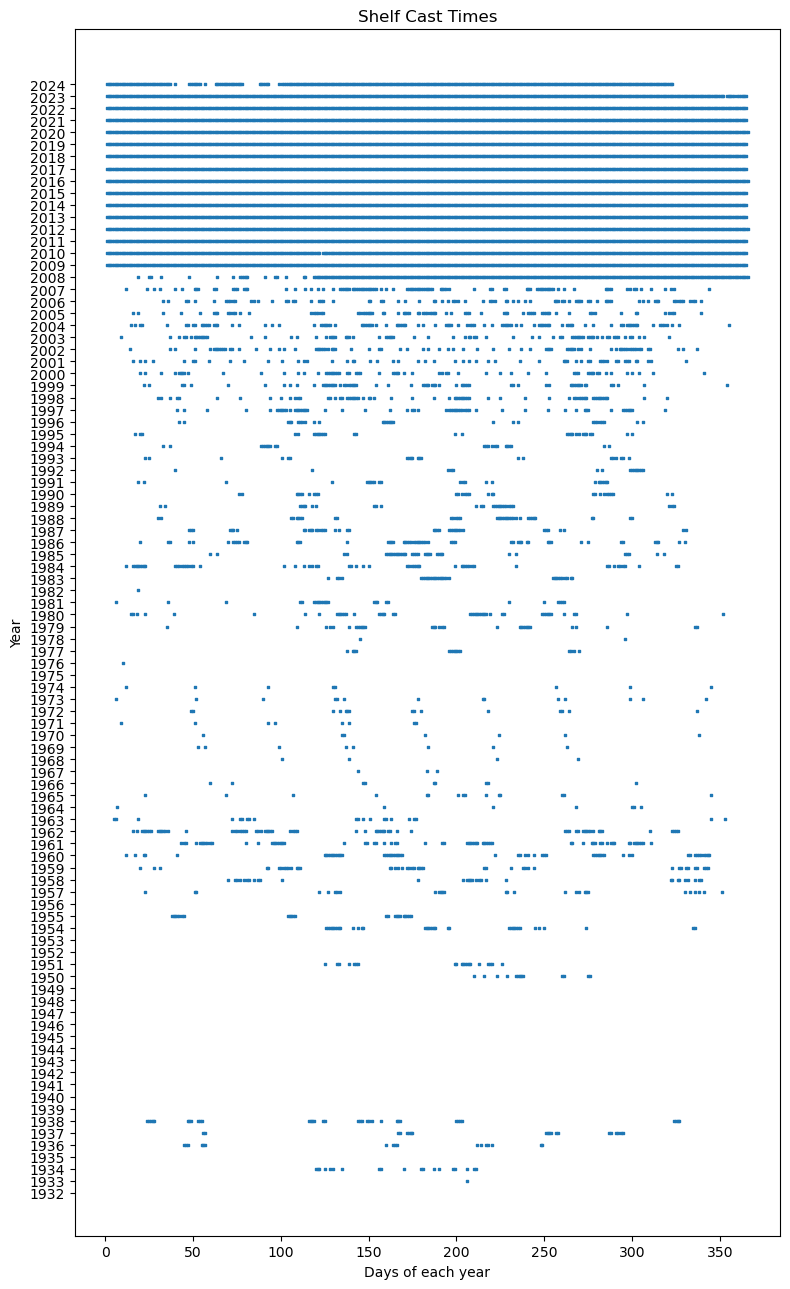

In [6]:
# Temporal resolution of Shelf Current
obs_shelf = obs[obs['current'] == 'Shelf_Current']

fig, ax = plt.subplots(figsize=(8, 13))

obs_shelf_dd = obs_shelf.drop_duplicates(subset='time', keep='first')

obs_shelf_dd['time'] = pd.to_datetime(obs_shelf_dd['time'])

yearDay = obs_shelf_dd['time'].dt.dayofyear
year = obs_shelf_dd['time'].dt.year

ax.scatter(yearDay, year, s=2, marker='s' )

ax.set_title('Shelf Cast Times')
ax.set_yticks(range(1932, 2025))  
ax.set_ylabel('Year')
ax.set_xlabel('Days of each year')

plt.tight_layout()
plt.show()

# Group by year and source, then count rows
grouped = obs_shelf.groupby(['year', 'source']).size().reset_index(name='count')

# Print results year by year
with open(OUTPATH+'/'+"ShelfCurrent_YearSource.txt", "w") as file:
    for year in sorted(grouped['year'].unique()):
        file.write(f"\n\nIn {year} there is:")
        sub = grouped[grouped['year'] == year]
        for _, row in sub.iterrows():
            file.write(f"\n    {row['source']}: {row['count']}")

/tmp/ipykernel_3544376/1244762139.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_cc_dd['time'] = pd.to_datetime(obs_cc_dd['time'])


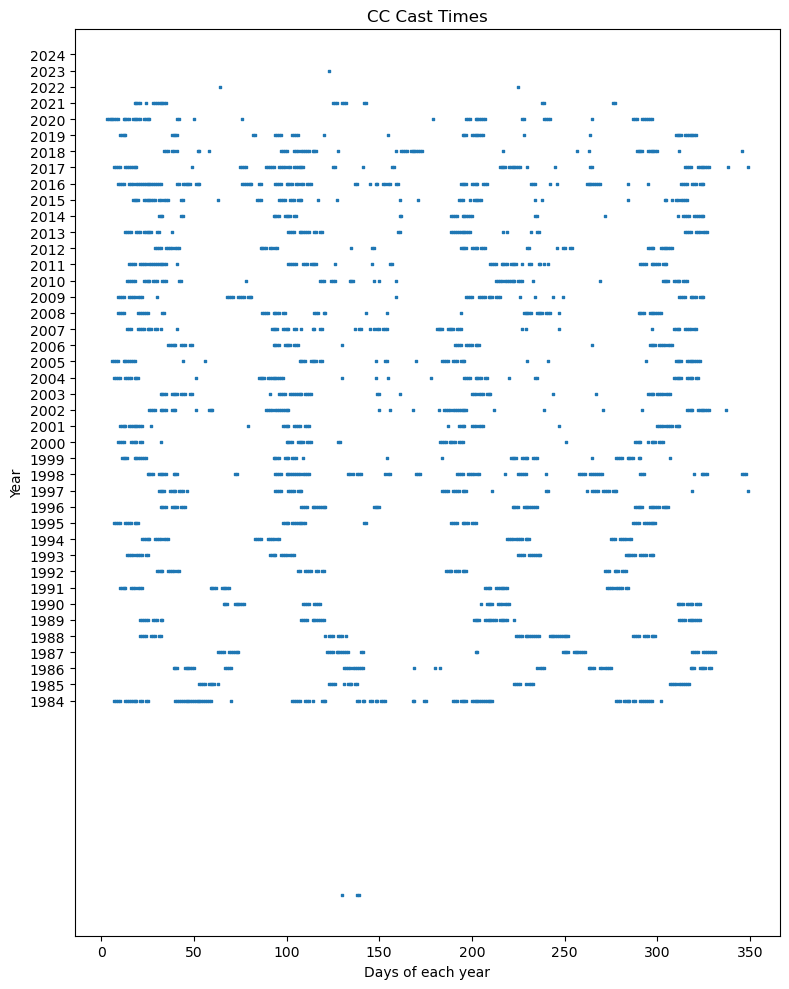

In [7]:
# Temporal resolution of California Current
obs_cc = obs[obs['current'] == 'CC']
fig, ax = plt.subplots(figsize=(8, 10))

obs_cc_dd = obs_cc.drop_duplicates(subset='time', keep='first')

obs_cc_dd['time'] = pd.to_datetime(obs_cc_dd['time'])

yearDay = obs_cc_dd['time'].dt.dayofyear
year = obs_cc_dd['time'].dt.year

ax.scatter(yearDay, year, s=2, marker='s' )
# ax.scatter(yearDay, year, s=2, marker='s', c=obs_cuc['month'], cmap='viridis')

ax.set_title('CC Cast Times')
ax.set_yticks(range(1984, 2025))  
ax.set_ylabel('Year')
ax.set_xlabel('Days of each year')


plt.tight_layout()
plt.show()

# Print results year by year
with open(OUTPATH+'/'+"CC_YearSource.txt", "w") as file:
    for year in sorted(grouped['year'].unique()):
        file.write(f"\n\nIn {year} there is:")
        sub = grouped[grouped['year'] == year]
        for _, row in sub.iterrows():
            file.write(f"\n    {row['source']}: {row['count']}")

/tmp/ipykernel_3544376/3438068512.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_cuc_dd['time'] = pd.to_datetime(obs_cuc_dd['time'])


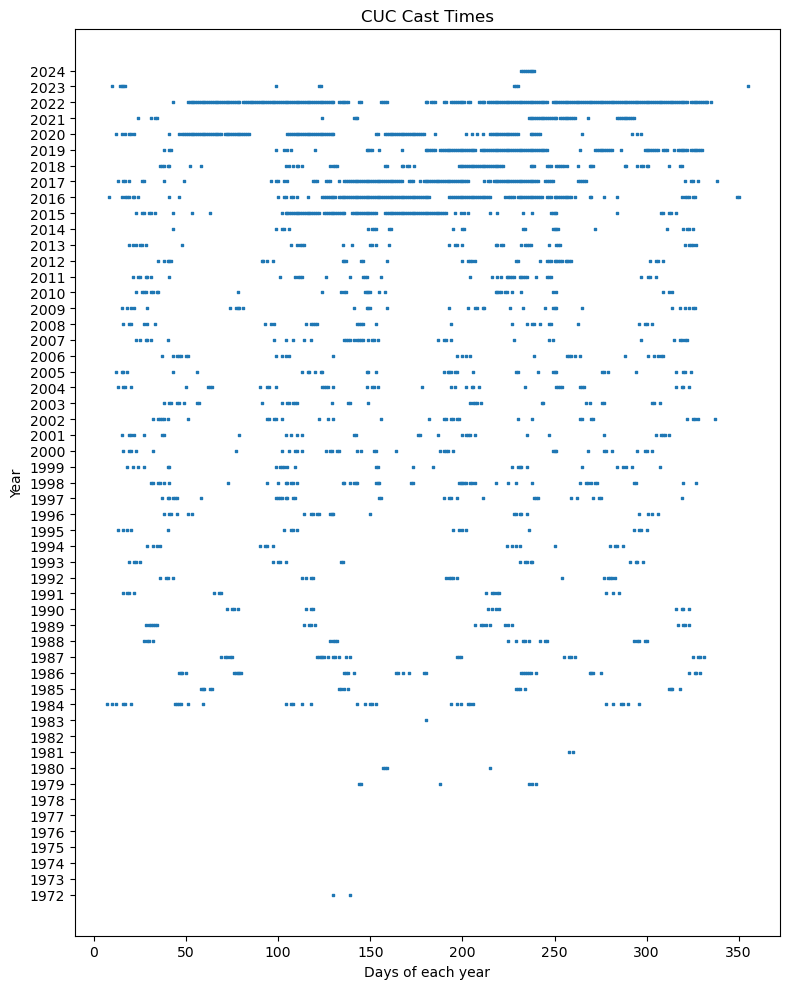

In [8]:
# Temporal resolution of California Under Current
obs_cuc = obs[obs['current'] == 'CUC']
fig, ax = plt.subplots(figsize=(8, 10))

obs_cuc_dd = obs_cuc.drop_duplicates(subset='time', keep='first')

obs_cuc_dd['time'] = pd.to_datetime(obs_cuc_dd['time'])

yearDay = obs_cuc_dd['time'].dt.dayofyear
year = obs_cuc_dd['time'].dt.year

ax.scatter(yearDay, year, s=2, marker='s' )
# ax.scatter(yearDay, year, s=2, marker='s', c=obs_cuc['month'], cmap='viridis')

ax.set_title('CUC Cast Times')
ax.set_yticks(range(1972, 2025))  
ax.set_ylabel('Year')
ax.set_xlabel('Days of each year')


plt.tight_layout()
plt.show()

# Print results year by year
with open(OUTPATH+'/'+"CUC_YearSource.txt", "w") as file:
    for year in sorted(grouped['year'].unique()):
        file.write(f"\n\nIn {year} there is:")
        sub = grouped[grouped['year'] == year]
        for _, row in sub.iterrows():
            file.write(f"\n    {row['source']}: {row['count']}")

Text(0.5, 1.0, 'Shelf Current Data Density')

Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #491 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included b

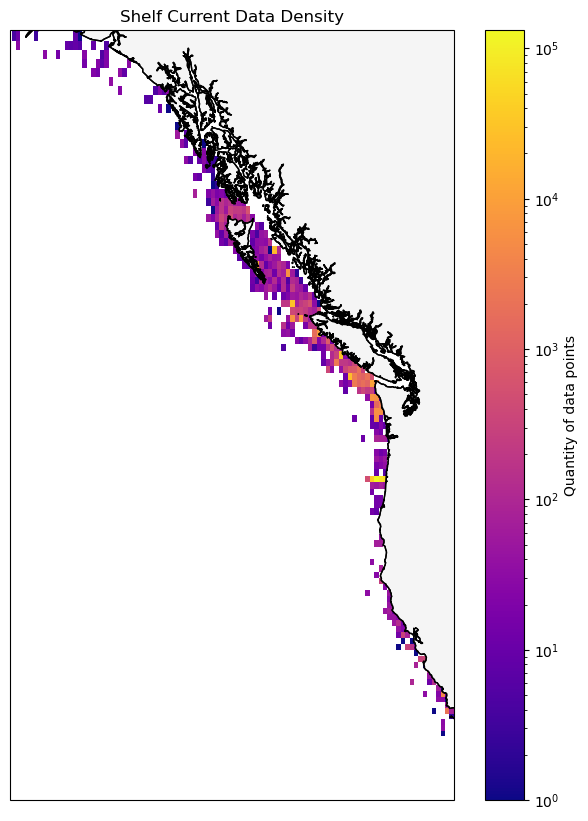

In [9]:
# Shelf Current Spatial Density
xlim, ylim = [-145.5, -120.2], [30, 60]

fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('intermediate', edgecolor='k', zorder=4))

# Prepare your data
lon = obs['longitude (degrees_east)'][obs['current'] == 'Shelf_Current']
lat = obs['latitude (degrees_north)'][obs['current'] == 'Shelf_Current']

# Create 2D histogram
hist, xedges, yedges = np.histogram2d(lon, lat, bins=100)

# Convert bin edges to meshgrid
xcenters = 0.5 * (xedges[:-1] + xedges[1:])
ycenters = 0.5 * (yedges[:-1] + yedges[1:])
X, Y = np.meshgrid(xcenters, ycenters)

# Plot using pcolormesh
pcm = ax.pcolormesh(X, Y, hist.T, cmap='plasma', norm='log', transform=crs.PlateCarree())
fig.colorbar(pcm, ax=ax, label="Quantity of data points")

ax.set_title('Shelf Current Data Density')

Text(0.5, 1.0, 'California Current Data Density')

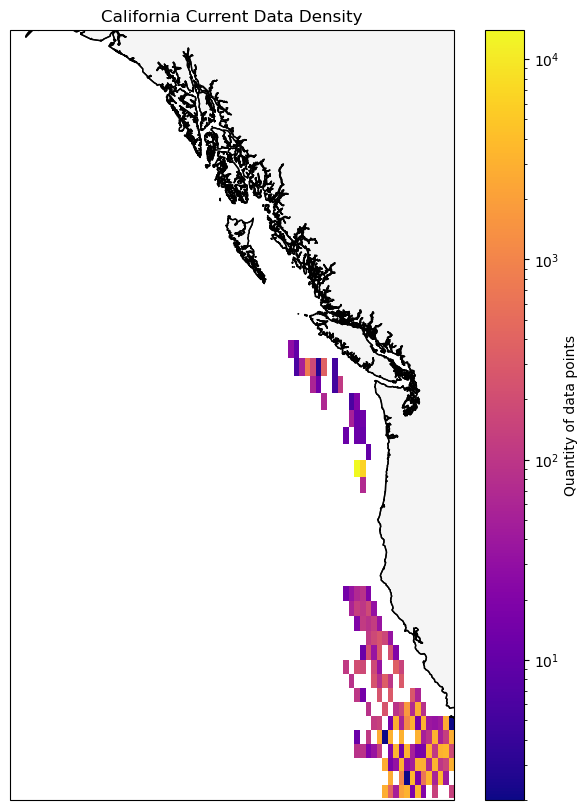

In [10]:
# CC Spatial Density
xlim, ylim = [-145.5, -120.2], [30, 60]

fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('intermediate', edgecolor='k', zorder=4))

# Prepare data
lon = obs['longitude (degrees_east)'][obs['current'] == 'CC']
lat = obs['latitude (degrees_north)'][obs['current'] == 'CC']

# Create 2D histogram
hist, xedges, yedges = np.histogram2d(lon, lat, bins=30)

# Convert bin edges to meshgrid
xcenters = 0.5 * (xedges[:-1] + xedges[1:])
ycenters = 0.5 * (yedges[:-1] + yedges[1:])
X, Y = np.meshgrid(xcenters, ycenters)

# Plot using pcolormesh
pcm = ax.pcolormesh(X, Y, hist.T, cmap='plasma', norm='log', transform=crs.PlateCarree())
fig.colorbar(pcm, ax=ax, label="Quantity of data points")

ax.set_title('California Current Data Density')

Text(0.5, 1.0, 'California Undercurrent Data Density')

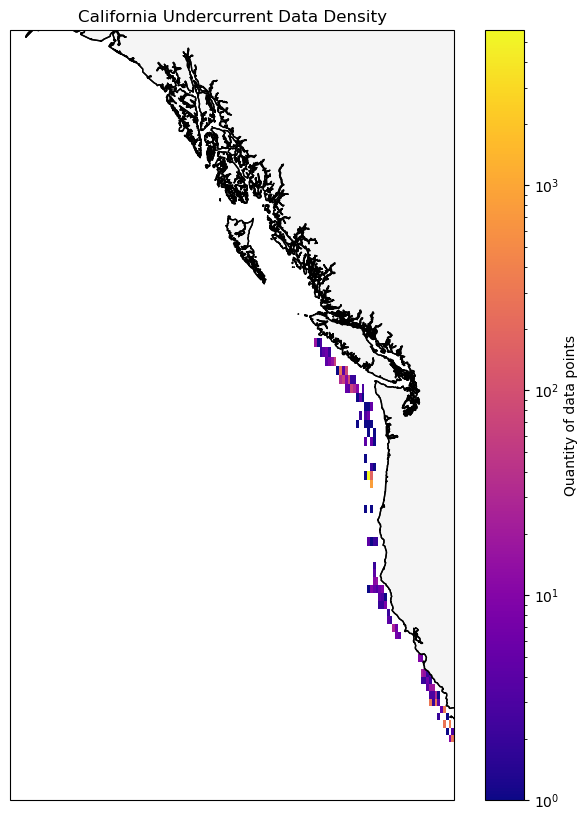

In [11]:
# CUC Spatial Density
xlim, ylim = [-145.5, -120.2], [30, 60]

fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('intermediate', edgecolor='k', zorder=4))

# Prepare data
lon = obs['longitude (degrees_east)'][obs['current'] == 'CUC']
lat = obs['latitude (degrees_north)'][obs['current'] == 'CUC']

# Create 2D histogram
hist, xedges, yedges = np.histogram2d(lon, lat, bins=50)

# Convert bin edges to meshgrid
xcenters = 0.5 * (xedges[:-1] + xedges[1:])
ycenters = 0.5 * (yedges[:-1] + yedges[1:])
X, Y = np.meshgrid(xcenters, ycenters)

# Plot using pcolormesh
pcm = ax.pcolormesh(X, Y, hist.T, cmap='plasma', norm='log', transform=crs.PlateCarree())
fig.colorbar(pcm, ax=ax, label="Quantity of data points")

ax.set_title('California Undercurrent Data Density')

## Selected Temperature Depth Anomaly plots

Text(0.5, 1.0, 'Shelf Current Temperature Anomaly (Avg per Year at Certain Depths)')

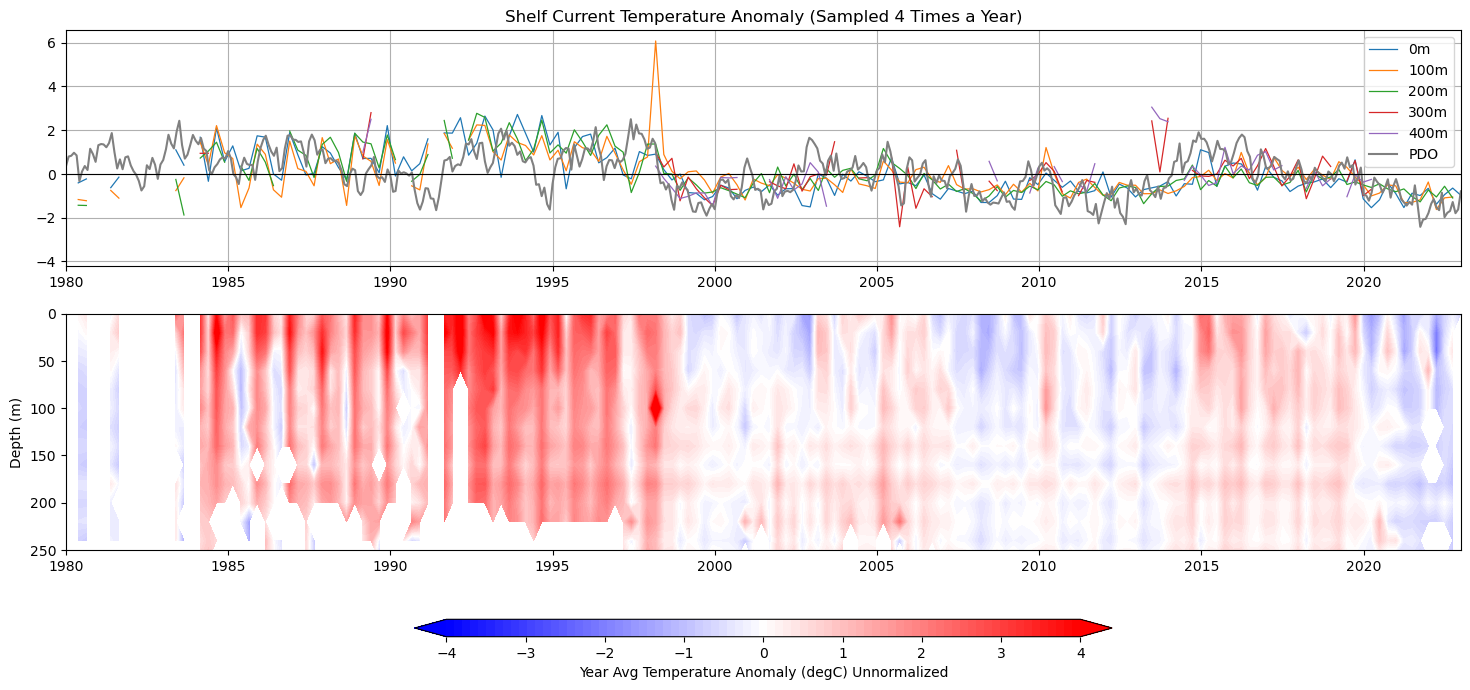

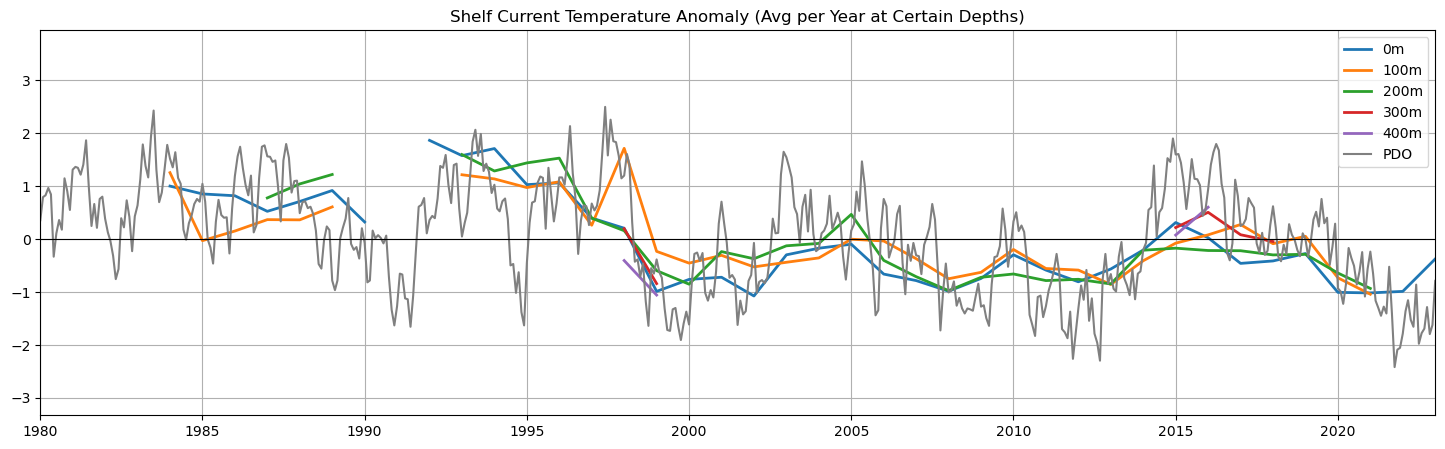

In [12]:
# Shelf Current temperature trends
obs_used = obs_shelf

start_yr = min(obs_used['year'])
end_yr = max(obs_used['year'])


depth_ranges = np.arange(0,500,20) # Every 20m depth range
variable_str = 'temperature (degC)' # Using temperature

anom_array = contour_prep_depth(obs_used, start_yr, end_yr, depth_ranges, variable_str)


x_yr_4times = np.linspace(start_yr, end_yr, num=(end_yr-start_yr)*4)
X,Y = np.meshgrid(x_yr_4times, depth_ranges[:-1])

fig, ax = plt.subplots(2,1, figsize=(18, 9))

for i in range(0, anom_array.shape[0], 5):
    dep_label = depth_ranges[i]
    ax[0].plot(x_yr_4times, zscore(anom_array[i], nan_policy='omit'), label=f'{dep_label}m', linewidth=0.9)

# ax[0].plot(enso['decimal_yr'], zscore(enso['index']), c='grey', ls='-', label='ENSO')
ax[0].plot(pdo['decimal_yr'], zscore(pdo['index']), c='grey', ls='-', label='PDO')
# ax[0].plot(npgo['decimal_yr'], zscore(npgo['index'], nan_policy='omit'), c='grey', ls='-', label='NPGO')

ax[0].set_xlim([1980,2023])
ax[0].legend()
ax[0].axhline(0, color='black', linewidth=0.8)
ax[0].grid()
ax[0].set_title('Shelf Current Temperature Anomaly (Sampled 4 Times a Year)')

vmax=4
levels = np.linspace(-vmax, vmax, 80)
cp = ax[1].contourf(X,Y, anom_array, levels=levels, cmap='bwr', extend='both')

ax[1].set_ylabel('Depth (m)')
ax[1].set_xlim([1980,2023])
ax[1].set_ylim([0,250])
ax[1].invert_yaxis()

ticks = list(range(-vmax, vmax+1))
cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.1, aspect=40, shrink=0.5, ticks=ticks)
cbar.set_label('Year Avg Temperature Anomaly (degC) Unnormalized')

##############################################################################
fig, ax = plt.subplots(1,1, figsize=(18, 5))
x_yr = np.arange(start_yr, end_yr)
for i in range(0, anom_array.shape[0], 5):
    dep_label = depth_ranges[i]
    averaged = zscore(anom_array[i], nan_policy='omit').reshape(-1, 4).mean(axis=1)
    ax.plot(x_yr, averaged, label=f'{dep_label}m', linewidth=2)

# ax[0].plot(enso['decimal_yr'], zscore(enso['index']), c='grey', ls='-', label='ENSO')
ax.plot(pdo['decimal_yr'], zscore(pdo['index']), c='grey', ls='-', label='PDO')
# ax[0].plot(npgo['decimal_yr'], zscore(npgo['index'], nan_policy='omit'), c='grey', ls='-', label='NPGO')

ax.set_xlim([1980,2023])
ax.legend()
ax.axhline(0, color='black', linewidth=0.8)
ax.grid()
ax.set_title('Shelf Current Temperature Anomaly (Avg per Year at Certain Depths)')


Text(0.5, 1.0, 'CC Temperature Anomaly (Avg per Year at Selected Depths)')

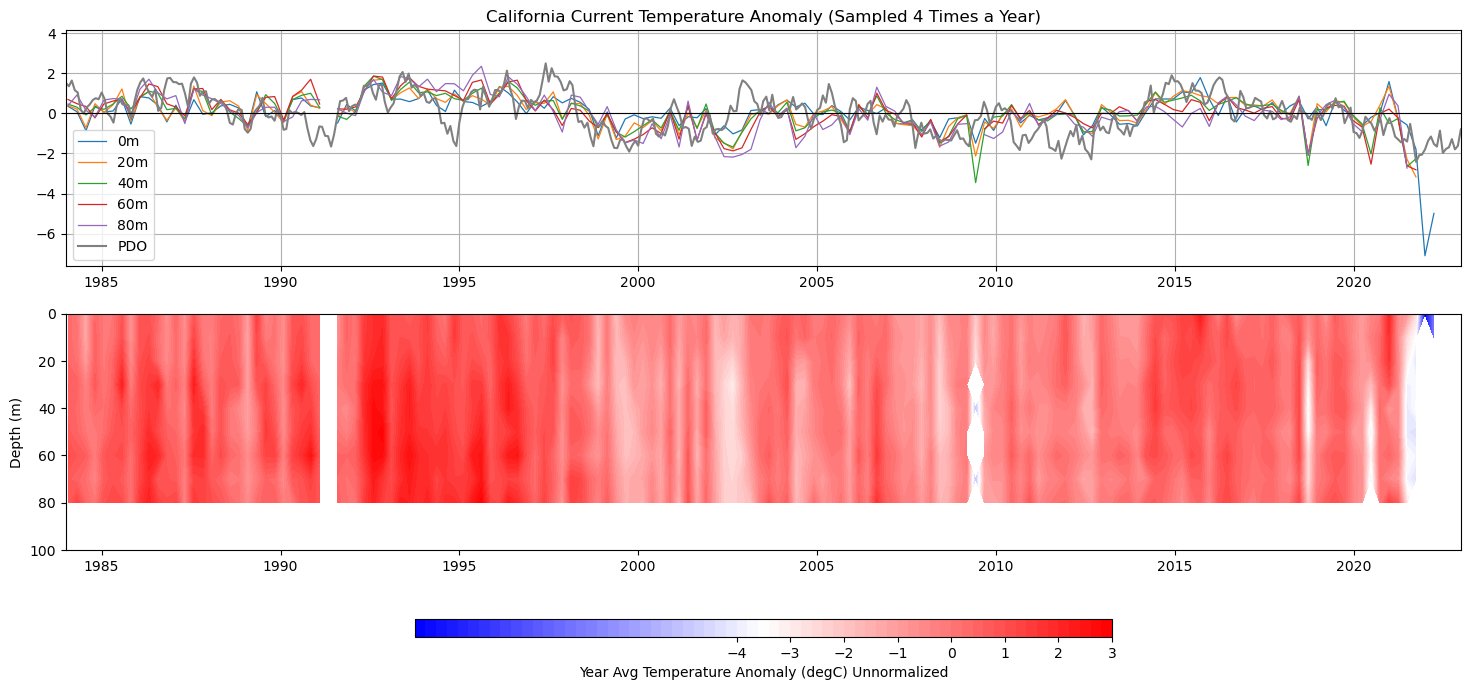

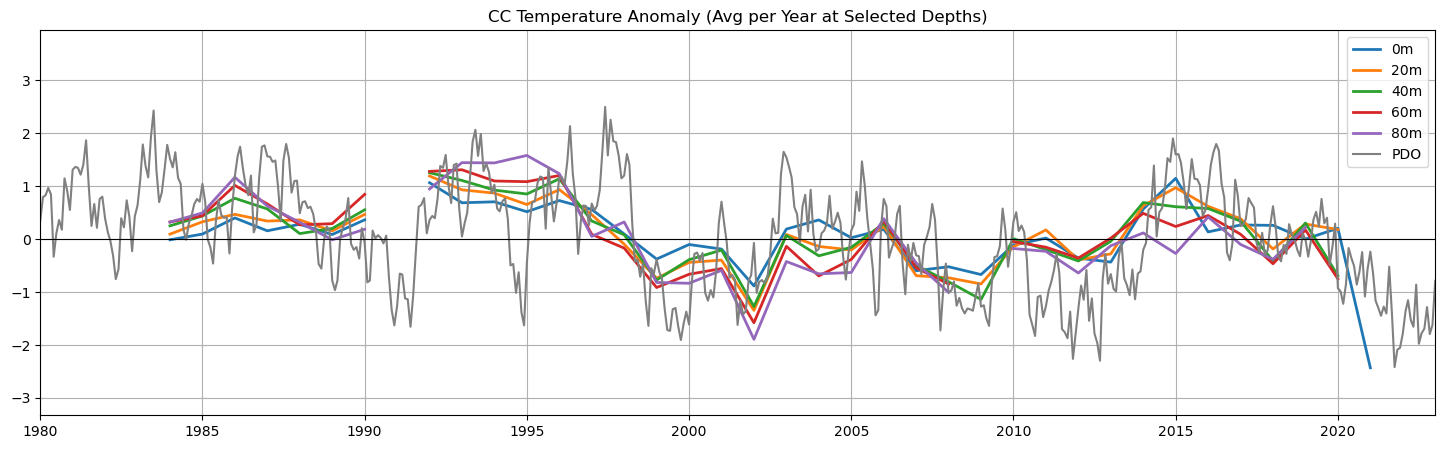

In [13]:
# California Current temperature depth trends
obs_used = obs_cc

start_yr = min(obs_used['year'])
end_yr = max(obs_used['year'])


depth_ranges = np.arange(0,100,10) # Every 10m depth range
variable_str = 'temperature (degC)' # Using temperature

anom_array = contour_prep_depth(obs_used, start_yr, end_yr, depth_ranges, variable_str)

x_yr_4times = np.linspace(start_yr, end_yr, num=(end_yr-start_yr)*4)
X,Y = np.meshgrid(x_yr_4times, depth_ranges[:-1])

fig, ax = plt.subplots(2,1, figsize=(18, 9))

for i in range(0, anom_array.shape[0], 2):
    dep_label = depth_ranges[i]
    ax[0].plot(x_yr_4times, zscore(anom_array[i], nan_policy='omit'), label=f'{dep_label}m', linewidth=0.9)

# ax[0].plot(enso['decimal_yr'], zscore(enso['index']), c='grey', ls='-', label='ENSO')
ax[0].plot(pdo['decimal_yr'], zscore(pdo['index']), c='grey', ls='-', label='PDO')
# ax[0].plot(npgo['decimal_yr'], zscore(npgo['index'], nan_policy='omit'), c='grey', ls='-', label='NPGO')

ax[0].set_xlim([1984,2023])
ax[0].legend()
ax[0].axhline(0, color='black', linewidth=0.8)
ax[0].grid()
ax[0].set_title('California Current Temperature Anomaly (Sampled 4 Times a Year)')

vmax=4
# levels = np.linspace(-vmax, vmax, 80)
# cp = ax[1].contourf(X,Y, anom_array, levels=levels, cmap='bwr', extend='both')

cp = ax[1].contourf(X,Y, anom_array, levels=80, cmap='bwr')

ax[1].set_ylabel('Depth (m)')
ax[1].set_xlim([1984,2023])
ax[1].set_ylim([0,100])
ax[1].invert_yaxis()

ticks = list(range(-vmax, vmax+1))
cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.1, aspect=40, shrink=0.5, ticks=ticks)
cbar.set_label('Year Avg Temperature Anomaly (degC) Unnormalized')

##############################################################################

fig, ax = plt.subplots(1,1, figsize=(18, 5))
x_yr = np.arange(start_yr, end_yr)
for i in range(0, anom_array.shape[0], 2):
    dep_label = depth_ranges[i]
    averaged = zscore(anom_array[i], nan_policy='omit').reshape(-1, 4).mean(axis=1)
    ax.plot(x_yr, averaged, label=f'{dep_label}m', linewidth=2)

# ax[0].plot(enso['decimal_yr'], zscore(enso['index']), c='grey', ls='-', label='ENSO')
ax.plot(pdo['decimal_yr'], zscore(pdo['index']), c='grey', ls='-', label='PDO')
# ax[0].plot(npgo['decimal_yr'], zscore(npgo['index'], nan_policy='omit'), c='grey', ls='-', label='NPGO')

ax.set_xlim([1980,2023])
ax.legend()
ax.axhline(0, color='black', linewidth=0.8)
ax.grid()
ax.set_title('CC Temperature Anomaly (Avg per Year at Selected Depths)')

/tmp/ipykernel_3544376/811006324.py:57: RuntimeWarning: Mean of empty slice
  averaged = np.nanmean(zscore(anom_array[idx], nan_policy='omit').reshape(-1, 4), axis=1)
/tmp/ipykernel_3544376/811006324.py:57: RuntimeWarning: Mean of empty slice
  averaged = np.nanmean(zscore(anom_array[idx], nan_policy='omit').reshape(-1, 4), axis=1)
/tmp/ipykernel_3544376/811006324.py:57: RuntimeWarning: Mean of empty slice
  averaged = np.nanmean(zscore(anom_array[idx], nan_policy='omit').reshape(-1, 4), axis=1)
/tmp/ipykernel_3544376/811006324.py:57: RuntimeWarning: Mean of empty slice
  averaged = np.nanmean(zscore(anom_array[idx], nan_policy='omit').reshape(-1, 4), axis=1)


Text(0.5, 1.0, 'California Undercurrent Temperature Anomaly (Avg per Year at Selected Depths)')

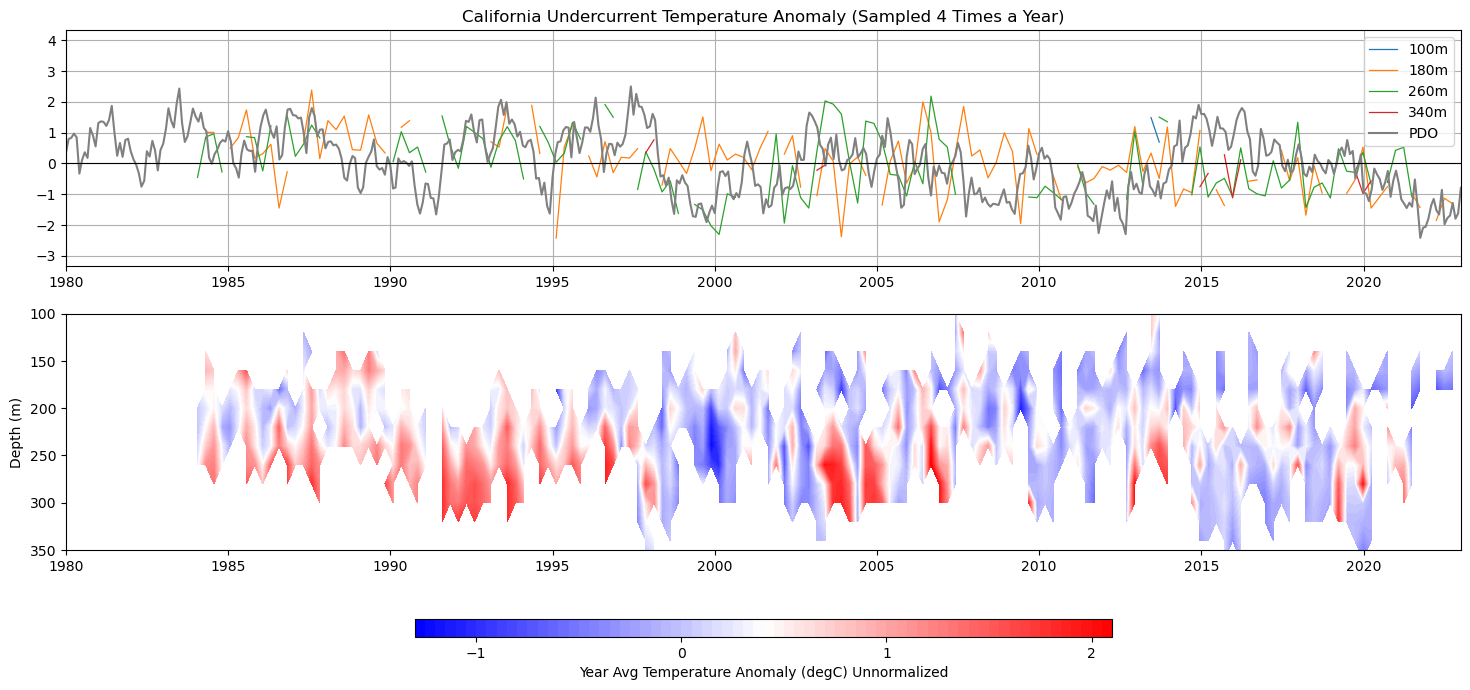

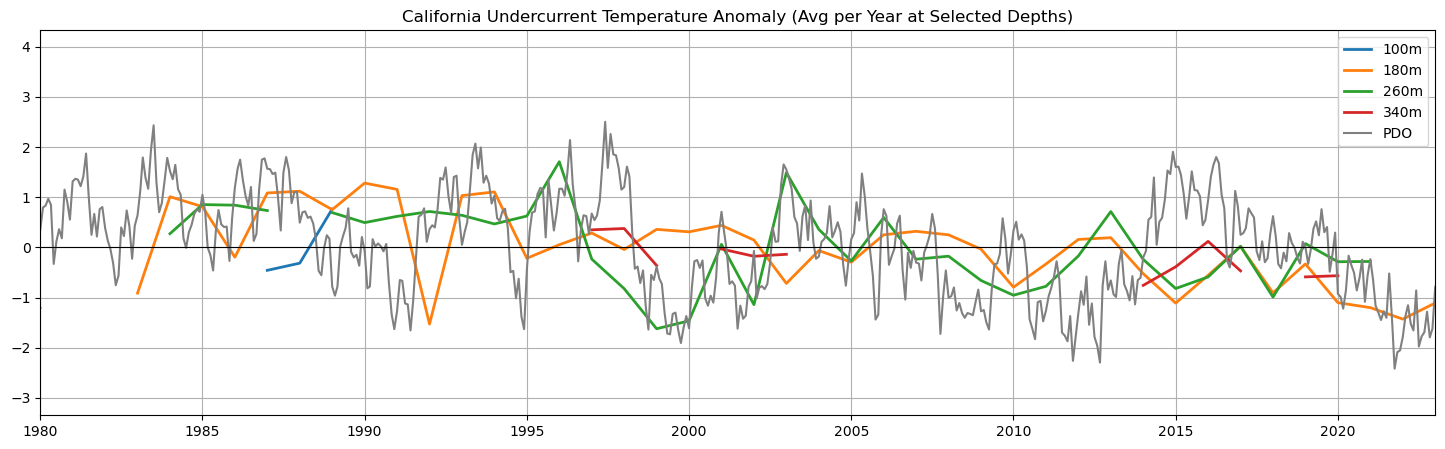

In [14]:
# California Undercurrent temperature depth trends
obs_used = obs_cuc

start_yr = min(obs_used['year'])
end_yr = max(obs_used['year'])


depth_ranges = np.arange(0,500,20) # Every 20m depth range
variable_str = 'temperature (degC)' # Using temperature

anom_array = contour_prep_depth(obs_used, start_yr, end_yr, depth_ranges, variable_str)

x_yr_4times = np.linspace(start_yr, end_yr, num=(end_yr-start_yr)*4)
X,Y = np.meshgrid(x_yr_4times, depth_ranges[:-1])

fig, ax = plt.subplots(2,1, figsize=(18, 9))

dep_mask = ((depth_ranges >= 100) & (depth_ranges <= 350))
masked_depths = np.where(dep_mask)[0]  # indices of depths in range 100–350

for idx in masked_depths[::4]:  # every 5th depth index in range
    dep_label = depth_ranges[idx]
    ax[0].plot(x_yr_4times, zscore(anom_array[idx], nan_policy='omit'), label=f'{dep_label}m', linewidth=0.9)

# ax[0].plot(enso['decimal_yr'], zscore(enso['index']), c='grey', ls='-', label='ENSO')
ax[0].plot(pdo['decimal_yr'], zscore(pdo['index']), c='grey', ls='-', label='PDO')
# ax[0].plot(npgo['decimal_yr'], zscore(npgo['index'], nan_policy='omit'), c='grey', ls='-', label='NPGO')

ax[0].set_xlim([1980,2023])
ax[0].legend()
ax[0].axhline(0, color='black', linewidth=0.8)
ax[0].grid()
ax[0].set_title('California Undercurrent Temperature Anomaly (Sampled 4 Times a Year)')

vmax=3
# levels = np.linspace(-vmax, vmax, 80)
# cp = ax[1].contourf(X,Y, anom_array, levels=levels, cmap='bwr', extend='both')

cp = ax[1].contourf(X,Y, anom_array, levels=80, cmap='bwr')

ax[1].set_ylabel('Depth (m)')
ax[1].set_xlim([1980,2023])
ax[1].set_ylim([100,350])
ax[1].invert_yaxis()

ticks = list(range(-vmax, vmax+1))
cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.1, aspect=40, shrink=0.5, ticks=ticks)
cbar.set_label('Year Avg Temperature Anomaly (degC) Unnormalized')

##############################################################################

fig, ax = plt.subplots(1,1, figsize=(18, 5))
x_yr = np.arange(start_yr, end_yr)

for idx in masked_depths[::4]:  # every 5th depth index in range
    dep_label = depth_ranges[idx]
    averaged = np.nanmean(zscore(anom_array[idx], nan_policy='omit').reshape(-1, 4), axis=1)
    ax.plot(x_yr, averaged, label=f'{dep_label}m', linewidth=2)


# ax.plot(enso['decimal_yr'], zscore(enso['index']), c='grey', ls='-', label='ENSO')
ax.plot(pdo['decimal_yr'], zscore(pdo['index']), c='grey', ls='-', label='PDO')
# ax.plot(npgo['decimal_yr'], zscore(npgo['index'], nan_policy='omit'), c='grey', ls='-', label='NPGO')

ax.set_xlim([1980,2023])
ax.legend()
ax.axhline(0, color='black', linewidth=0.8)
ax.grid()
ax.set_title('California Undercurrent Temperature Anomaly (Avg per Year at Selected Depths)')


## Salinity Depth Anomaly Plots

Text(0.5, 1.0, 'Shelf Current Salinity Anomaly (Avg per Year at Selected Depths)')

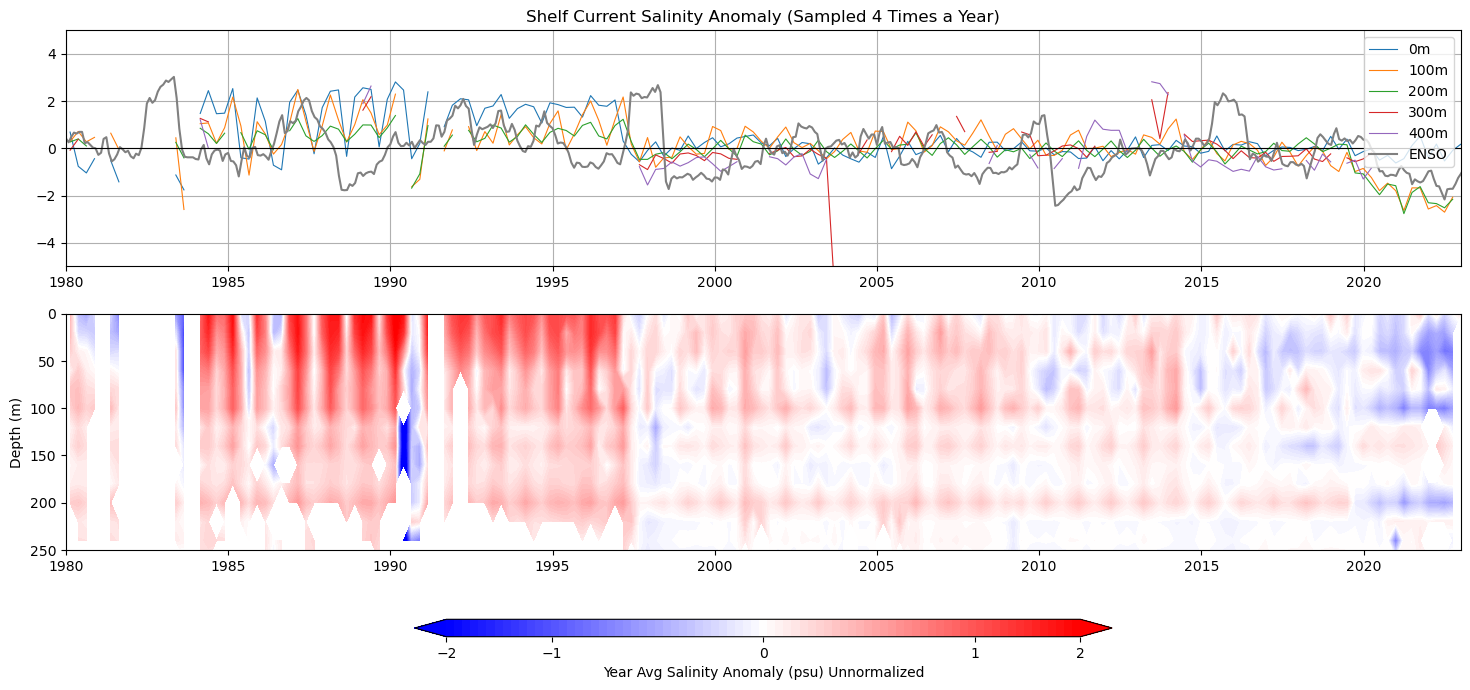

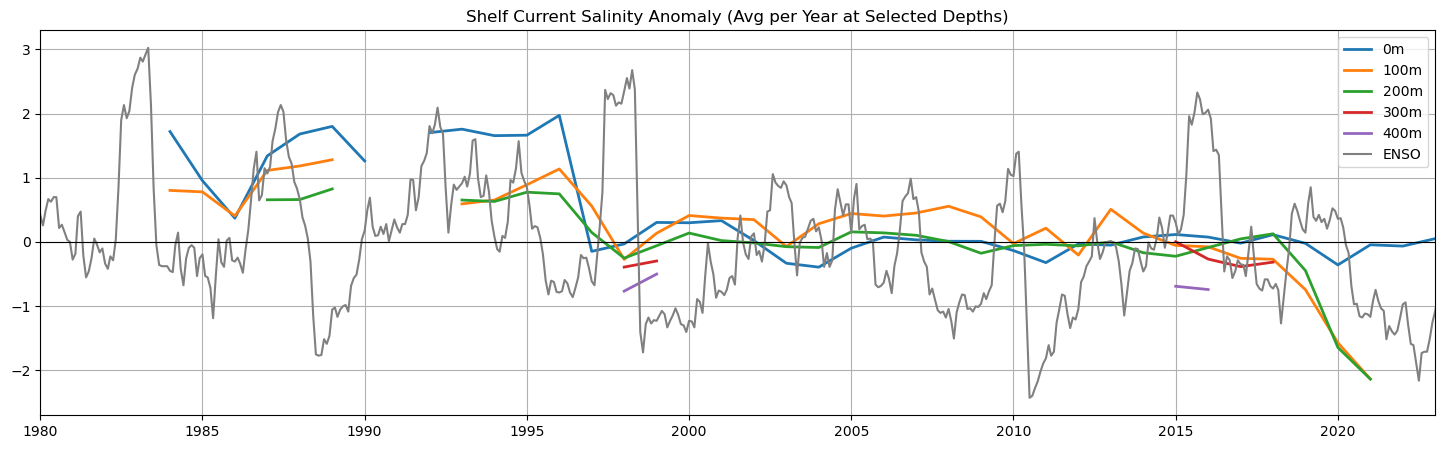

In [15]:
# Shelf Current salinity trends
obs_used = obs_shelf

start_yr = min(obs_used['year'])
end_yr = max(obs_used['year'])


depth_ranges = np.arange(0,500,20) # Every 20m depth range
variable_str = 'salinity (psu)' # Using salinity

anom_array = contour_prep_depth(obs_used, start_yr, end_yr, depth_ranges, variable_str)


x_yr_4times = np.linspace(start_yr, end_yr, num=(end_yr-start_yr)*4)
X,Y = np.meshgrid(x_yr_4times, depth_ranges[:-1])

fig, ax = plt.subplots(2,1, figsize=(18, 9))

for i in range(0, anom_array.shape[0], 5):
    dep_label = depth_ranges[i]
    ax[0].plot(x_yr_4times, zscore(anom_array[i], nan_policy='omit'), label=f'{dep_label}m', linewidth=0.8)

ax[0].plot(enso['decimal_yr'], zscore(enso['index']), c='grey', ls='-', label='ENSO')
# ax[0].plot(pdo['decimal_yr'], zscore(pdo['index']), c='grey', ls='-', label='PDO')
# ax[0].plot(npgo['decimal_yr'], zscore(npgo['index'], nan_policy='omit'), c='grey', ls='-', label='NPGO')

ax[0].set_xlim([1980,2023])
ax[0].set_ylim([-5,5])
ax[0].legend()
ax[0].axhline(0, color='black', linewidth=0.8)
ax[0].grid()
ax[0].set_title('Shelf Current Salinity Anomaly (Sampled 4 Times a Year)')

vmax=1.5
levels = np.linspace(-vmax, vmax, 80)
cp = ax[1].contourf(X,Y, anom_array, levels=levels, cmap='bwr', extend='both')

ax[1].set_ylabel('Depth (m)')
ax[1].set_xlim([1980,2023])
ax[1].set_ylim([0,250])
ax[1].invert_yaxis()

ticks = list(range(-2, 2+1))
cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.1, aspect=40, shrink=0.5, ticks=ticks)
cbar.set_label('Year Avg Salinity Anomaly (psu) Unnormalized')

##############################################################################

fig, ax = plt.subplots(1,1, figsize=(18, 5))
x_yr = np.arange(start_yr, end_yr)
for i in range(0, anom_array.shape[0], 5):
    dep_label = depth_ranges[i]
    averaged = zscore(anom_array[i], nan_policy='omit').reshape(-1, 4).mean(axis=1)
    ax.plot(x_yr, averaged, label=f'{dep_label}m', linewidth=2)

ax.plot(enso['decimal_yr'], zscore(enso['index']), c='grey', ls='-', label='ENSO')
# ax.plot(pdo['decimal_yr'], zscore(pdo['index']), c='grey', ls='-', label='PDO')
# ax[0].plot(npgo['decimal_yr'], zscore(npgo['index'], nan_policy='omit'), c='grey', ls='-', label='NPGO')

ax.set_xlim([1980,2023])
ax.legend()
ax.axhline(0, color='black', linewidth=0.8)
ax.grid()
ax.set_title('Shelf Current Salinity Anomaly (Avg per Year at Selected Depths)')


Text(0.5, 1.0, 'California Current Salinity Anomaly (Avg per Year at Selected Depths)')

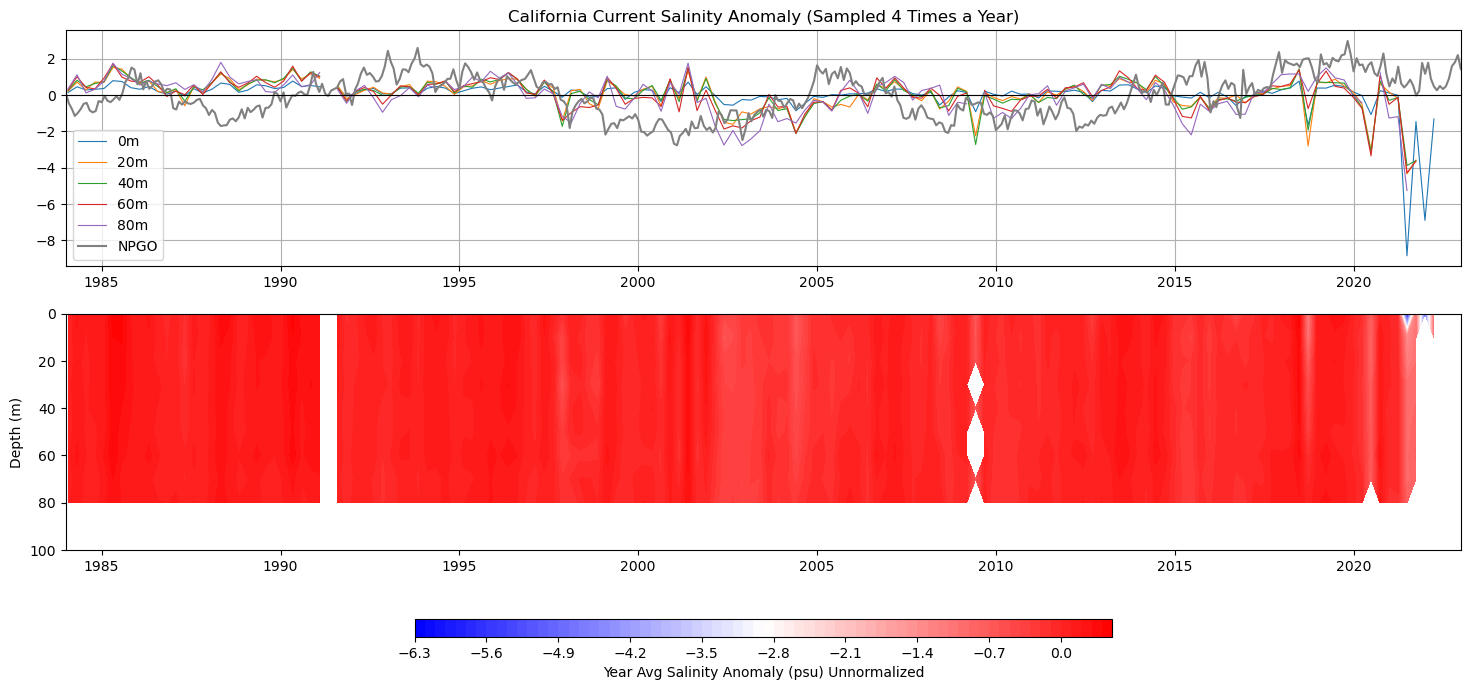

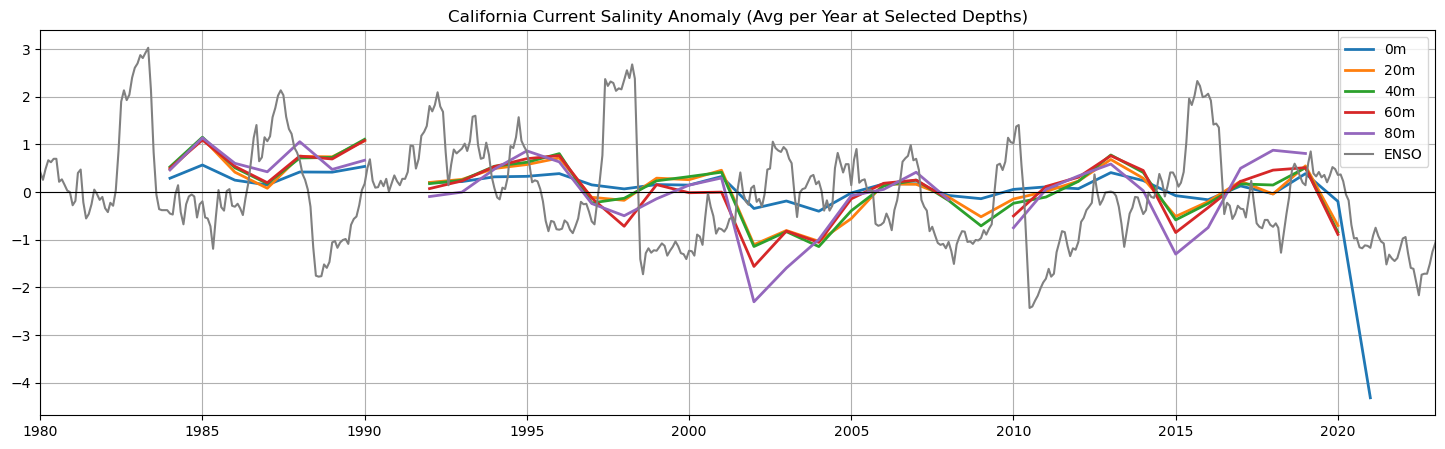

In [16]:
# California Current salinity trends
obs_used = obs_cc

start_yr = min(obs_used['year'])
end_yr = max(obs_used['year'])


depth_ranges = np.arange(0,100,10) # Every 10m depth range
variable_str = 'salinity (psu)' # Using salinity

anom_array = contour_prep_depth(obs_used, start_yr, end_yr, depth_ranges, variable_str)

x_yr_4times = np.linspace(start_yr, end_yr, num=(end_yr-start_yr)*4)
X,Y = np.meshgrid(x_yr_4times, depth_ranges[:-1])

fig, ax = plt.subplots(2,1, figsize=(18, 9))

for i in range(0, anom_array.shape[0], 2):
    dep_label = depth_ranges[i]
    ax[0].plot(x_yr_4times, zscore(anom_array[i], nan_policy='omit'), label=f'{dep_label}m', linewidth=0.8)

# ax[0].plot(enso['decimal_yr'], zscore(enso['index']), c='grey', ls='-', label='ENSO')
# ax[0].plot(pdo['decimal_yr'], zscore(pdo['index']), c='grey', ls='-', label='PDO')
ax[0].plot(npgo['decimal_yr'], -zscore(npgo['index'], nan_policy='omit'), c='grey', ls='-', label='NPGO')

ax[0].set_xlim([1984,2023])
ax[0].legend()
ax[0].axhline(0, color='black', linewidth=0.8)
ax[0].grid()
ax[0].set_title('California Current Salinity Anomaly (Sampled 4 Times a Year)')

vmax=3
# levels = np.linspace(-vmax, vmax, 80)
# cp = ax[1].contourf(X,Y, anom_array, levels=levels, cmap='bwr', extend='both')

cp = ax[1].contourf(X,Y, anom_array, levels=80, cmap='bwr')

ax[1].set_ylabel('Depth (m)')
ax[1].set_xlim([1984,2023])
ax[1].set_ylim([0,100])
ax[1].invert_yaxis()

# ticks = [-1, -0.5, 0, 0.5, 1, 1.5]
cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.1, aspect=40, shrink=0.5)#, ticks=ticks)
cbar.set_label('Year Avg Salinity Anomaly (psu) Unnormalized')

##############################################################################

fig, ax = plt.subplots(1,1, figsize=(18, 5))
x_yr = np.arange(start_yr, end_yr)
for i in range(0, anom_array.shape[0], 2):
    dep_label = depth_ranges[i]
    averaged = zscore(anom_array[i], nan_policy='omit').reshape(-1, 4).mean(axis=1)
    ax.plot(x_yr, averaged, label=f'{dep_label}m', linewidth=2)

ax.plot(enso['decimal_yr'], zscore(enso['index']), c='grey', ls='-', label='ENSO')
# ax.plot(pdo['decimal_yr'], zscore(pdo['index']), c='grey', ls='-', label='PDO')
# ax[0].plot(npgo['decimal_yr'], zscore(npgo['index'], nan_policy='omit'), c='grey', ls='-', label='NPGO')

ax.set_xlim([1980,2023])
ax.legend()
ax.axhline(0, color='black', linewidth=0.8)
ax.grid()
ax.set_title('California Current Salinity Anomaly (Avg per Year at Selected Depths)')

/tmp/ipykernel_3544376/1384644514.py:57: RuntimeWarning: Mean of empty slice
  averaged = np.nanmean(zscore(anom_array[idx], nan_policy='omit').reshape(-1, 4), axis=1)
/tmp/ipykernel_3544376/1384644514.py:57: RuntimeWarning: Mean of empty slice
  averaged = np.nanmean(zscore(anom_array[idx], nan_policy='omit').reshape(-1, 4), axis=1)
/tmp/ipykernel_3544376/1384644514.py:57: RuntimeWarning: Mean of empty slice
  averaged = np.nanmean(zscore(anom_array[idx], nan_policy='omit').reshape(-1, 4), axis=1)
/tmp/ipykernel_3544376/1384644514.py:57: RuntimeWarning: Mean of empty slice
  averaged = np.nanmean(zscore(anom_array[idx], nan_policy='omit').reshape(-1, 4), axis=1)


Text(0.5, 1.0, 'California Undercurrent Salinity Anomaly (Avg per Year at Selected Depths)')

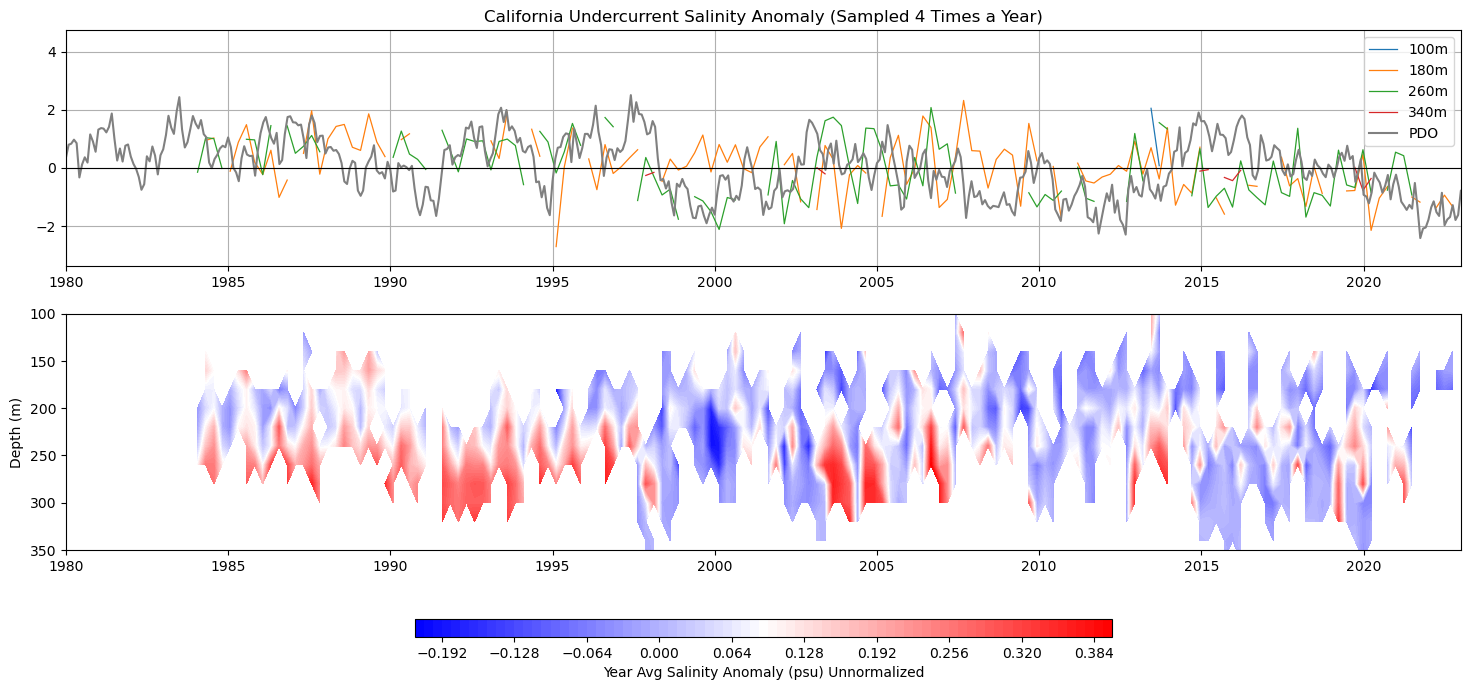

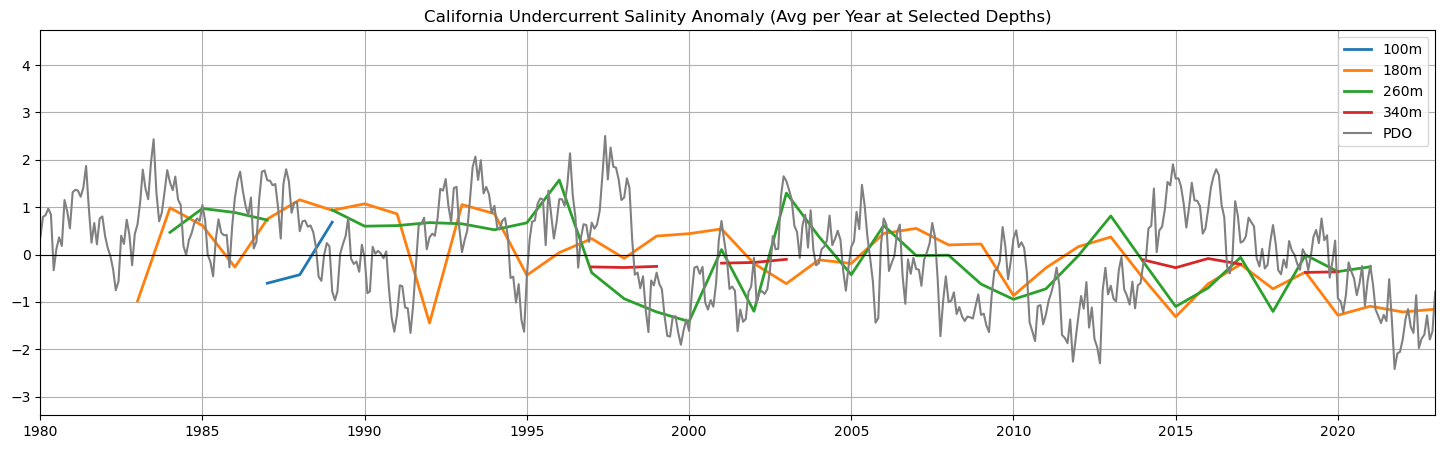

In [17]:
# California Undercurrent salinity trends
obs_used = obs_cuc

start_yr = min(obs_used['year'])
end_yr = max(obs_used['year'])


depth_ranges = np.arange(0,500,20) # Every 20m depth range
variable_str = 'salinity (psu)' # Using salinity

anom_array = contour_prep_depth(obs_used, start_yr, end_yr, depth_ranges, variable_str)

x_yr_4times = np.linspace(start_yr, end_yr, num=(end_yr-start_yr)*4)
X,Y = np.meshgrid(x_yr_4times, depth_ranges[:-1])

fig, ax = plt.subplots(2,1, figsize=(18, 9))

dep_mask = ((depth_ranges >= 100) & (depth_ranges <= 350))
masked_depths = np.where(dep_mask)[0]  # indices of depths in range 100–350

for idx in masked_depths[::4]:  # every 5th depth index in range
    dep_label = depth_ranges[idx]
    ax[0].plot(x_yr_4times, zscore(anom_array[idx], nan_policy='omit'), label=f'{dep_label}m', linewidth=0.9)

# ax[0].plot(enso['decimal_yr'], zscore(enso['index']), c='grey', ls='-', label='ENSO')
ax[0].plot(pdo['decimal_yr'], zscore(pdo['index']), c='grey', ls='-', label='PDO')
# ax[0].plot(npgo['decimal_yr'], zscore(npgo['index'], nan_policy='omit'), c='grey', ls='-', label='NPGO')

ax[0].set_xlim([1980,2023])
ax[0].legend()
ax[0].axhline(0, color='black', linewidth=0.8)
ax[0].grid()
ax[0].set_title('California Undercurrent Salinity Anomaly (Sampled 4 Times a Year)')

vmax=3
# levels = np.linspace(-vmax, vmax, 80)
# cp = ax[1].contourf(X,Y, anom_array, levels=levels, cmap='bwr', extend='both')

cp = ax[1].contourf(X,Y, anom_array, levels=80, cmap='bwr')

ax[1].set_ylabel('Depth (m)')
ax[1].set_xlim([1980,2023])
ax[1].set_ylim([100,350])
ax[1].invert_yaxis()

# ticks = [-1, -0.5, 0, 0.5, 1, 1.5]
cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.1, aspect=40, shrink=0.5)#, ticks=ticks)
cbar.set_label('Year Avg Salinity Anomaly (psu) Unnormalized')

##############################################################################

fig, ax = plt.subplots(1,1, figsize=(18, 5))
x_yr = np.arange(start_yr, end_yr)

for idx in masked_depths[::4]:  # every 5th depth index in range
    dep_label = depth_ranges[idx]
    averaged = np.nanmean(zscore(anom_array[idx], nan_policy='omit').reshape(-1, 4), axis=1)
    ax.plot(x_yr, averaged, label=f'{dep_label}m', linewidth=2)


# ax[0].plot(enso['decimal_yr'], zscore(enso['index']), c='grey', ls='-', label='ENSO')
ax.plot(pdo['decimal_yr'], zscore(pdo['index']), c='grey', ls='-', label='PDO')
# ax[0].plot(npgo['decimal_yr'], zscore(npgo['index'], nan_policy='omit'), c='grey', ls='-', label='NPGO')

ax.set_xlim([1980,2023])
ax.legend()
ax.axhline(0, color='black', linewidth=0.8)
ax.grid()
ax.set_title('California Undercurrent Salinity Anomaly (Avg per Year at Selected Depths)')

## Oxygen Anomaly Plots

/tmp/ipykernel_3544376/440757331.py:26: RuntimeWarning: Mean of empty slice
  averaged = np.nanmean(zscore(anom_array[idx], nan_policy='omit').reshape(-1, 4), axis=1)
/tmp/ipykernel_3544376/440757331.py:26: RuntimeWarning: Mean of empty slice
  averaged = np.nanmean(zscore(anom_array[idx], nan_policy='omit').reshape(-1, 4), axis=1)
/tmp/ipykernel_3544376/440757331.py:26: RuntimeWarning: Mean of empty slice
  averaged = np.nanmean(zscore(anom_array[idx], nan_policy='omit').reshape(-1, 4), axis=1)
/tmp/ipykernel_3544376/440757331.py:26: RuntimeWarning: Mean of empty slice
  averaged = np.nanmean(zscore(anom_array[idx], nan_policy='omit').reshape(-1, 4), axis=1)


Text(0.5, 1.0, 'California Undercurrent DO Anomaly (Avg per Year at Selected Depths)')

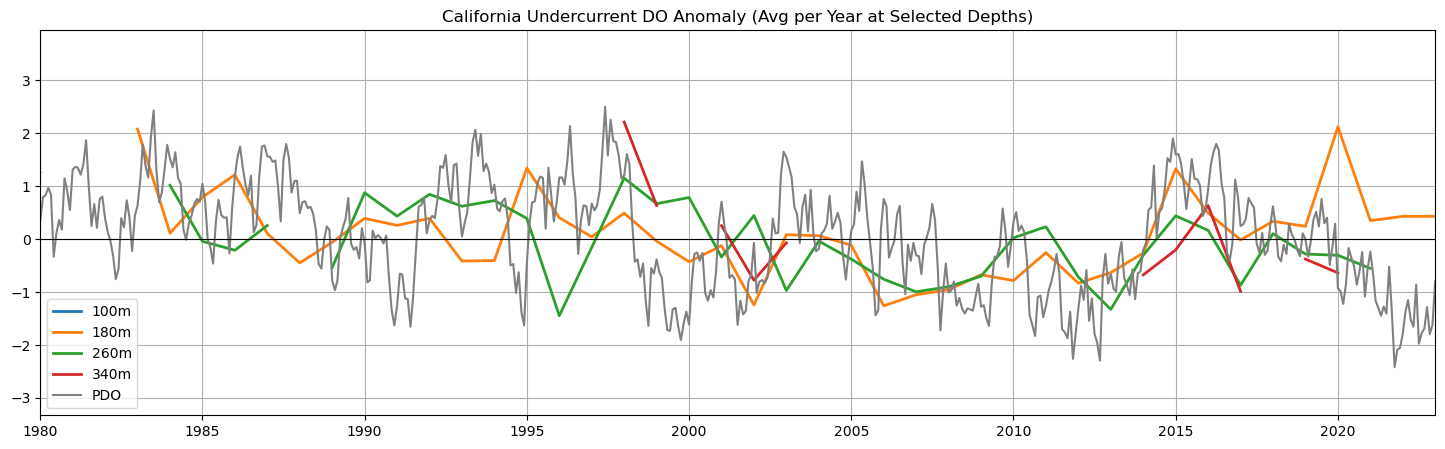

In [18]:
# California Undercurrent DO trends
obs_used = obs_cuc

start_yr = min(obs_used['year'])
end_yr = max(obs_used['year'])


depth_ranges = np.arange(0,500,20) # Every 20m depth range
variable_str = 'DO (umol kg-1)' # Using DO

anom_array = contour_prep_depth(obs_used, start_yr, end_yr, depth_ranges, variable_str)

x_yr_4times = np.linspace(start_yr, end_yr, num=(end_yr-start_yr)*4)
X,Y = np.meshgrid(x_yr_4times, depth_ranges[:-1])

dep_mask = ((depth_ranges >= 100) & (depth_ranges <= 350))
masked_depths = np.where(dep_mask)[0]  # indices of depths in range 100–350

##############################################################################

fig, ax = plt.subplots(1,1, figsize=(18, 5))
x_yr = np.arange(start_yr, end_yr)

for idx in masked_depths[::4]:  # every 5th depth index in range
    dep_label = depth_ranges[idx]
    averaged = np.nanmean(zscore(anom_array[idx], nan_policy='omit').reshape(-1, 4), axis=1)
    ax.plot(x_yr, averaged, label=f'{dep_label}m', linewidth=2)


# ax[0].plot(enso['decimal_yr'], zscore(enso['index']), c='grey', ls='-', label='ENSO')
ax.plot(pdo['decimal_yr'], zscore(pdo['index']), c='grey', ls='-', label='PDO')
# ax[0].plot(npgo['decimal_yr'], zscore(npgo['index'], nan_policy='omit'), c='grey', ls='-', label='NPGO')

ax.set_xlim([1980,2023])
ax.legend()
ax.axhline(0, color='black', linewidth=0.8)
ax.grid()
ax.set_title('California Undercurrent DO Anomaly (Avg per Year at Selected Depths)')

Text(0.5, 1.0, 'California Current DO Anomaly (Avg per Year at Selected Depths)')

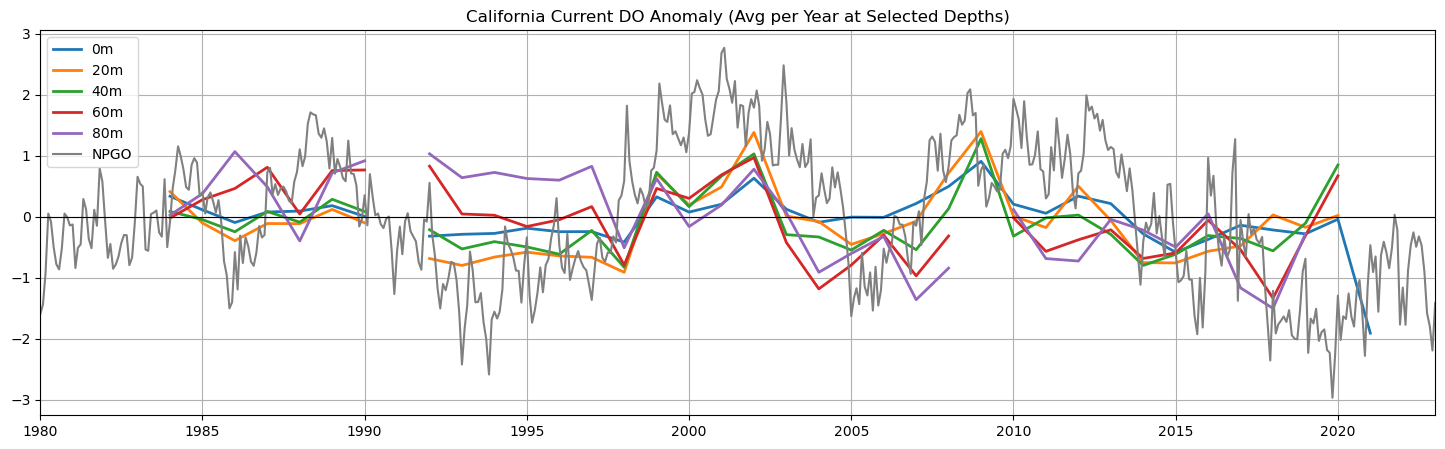

In [19]:
# California Current salinity trends
obs_used = obs_cc

start_yr = min(obs_used['year'])
end_yr = max(obs_used['year'])


depth_ranges = np.arange(0,100,10) # Every 10m depth range
variable_str = 'DO (umol kg-1)' # Using DO

anom_array = contour_prep_depth(obs_used, start_yr, end_yr, depth_ranges, variable_str)

x_yr_4times = np.linspace(start_yr, end_yr, num=(end_yr-start_yr)*4)
X,Y = np.meshgrid(x_yr_4times, depth_ranges[:-1])

##############################################################################

fig, ax = plt.subplots(1,1, figsize=(18, 5))
x_yr = np.arange(start_yr, end_yr)
for i in range(0, anom_array.shape[0], 2):
    dep_label = depth_ranges[i]
    averaged = zscore(anom_array[i], nan_policy='omit').reshape(-1, 4).mean(axis=1)
    ax.plot(x_yr, averaged, label=f'{dep_label}m', linewidth=2)

# ax.plot(enso['decimal_yr'], zscore(enso['index']), c='grey', ls='-', label='ENSO')
# ax.plot(pdo['decimal_yr'], zscore(pdo['index']), c='grey', ls='-', label='PDO')
ax.plot(npgo['decimal_yr'], zscore(npgo['index'], nan_policy='omit'), c='grey', ls='-', label='NPGO')

ax.set_xlim([1980,2023])
ax.legend()
ax.axhline(0, color='black', linewidth=0.8)
ax.grid()
ax.set_title('California Current DO Anomaly (Avg per Year at Selected Depths)')

Text(0.5, 1.0, 'Shelf Current DO Anomaly (Avg per Year at Selected Depths)')

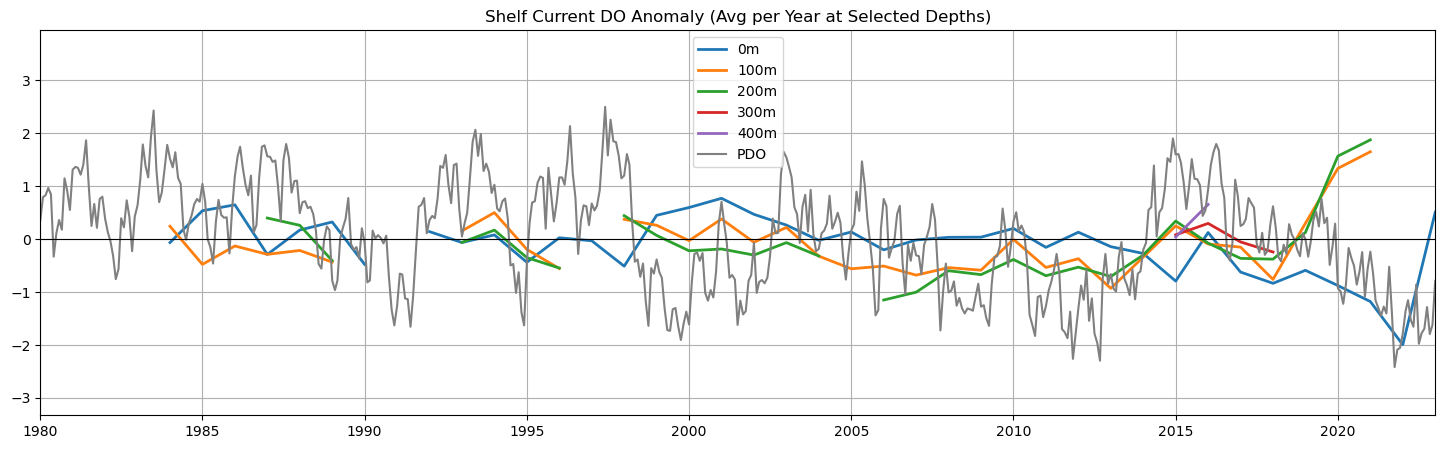

In [20]:
# Shelf Current DO trends
obs_used = obs_shelf

start_yr = min(obs_used['year'])
end_yr = max(obs_used['year'])


depth_ranges = np.arange(0,500,20) # Every 20m depth range
variable_str = 'DO (umol kg-1)' # Using DO

anom_array = contour_prep_depth(obs_used, start_yr, end_yr, depth_ranges, variable_str)


x_yr_4times = np.linspace(start_yr, end_yr, num=(end_yr-start_yr)*4)
X,Y = np.meshgrid(x_yr_4times, depth_ranges[:-1])

##############################################################################

fig, ax = plt.subplots(1,1, figsize=(18, 5))
x_yr = np.arange(start_yr, end_yr)
for i in range(0, anom_array.shape[0], 5):
    dep_label = depth_ranges[i]
    averaged = zscore(anom_array[i], nan_policy='omit').reshape(-1, 4).mean(axis=1)
    ax.plot(x_yr, averaged, label=f'{dep_label}m', linewidth=2)

# ax.plot(enso['decimal_yr'], zscore(enso['index']), c='grey', ls='-', label='ENSO')
ax.plot(pdo['decimal_yr'], zscore(pdo['index']), c='grey', ls='-', label='PDO')
# ax.plot(npgo['decimal_yr'], zscore(npgo['index'], nan_policy='omit'), c='grey', ls='-', label='NPGO')

ax.set_xlim([1980,2023])
ax.legend()
ax.axhline(0, color='black', linewidth=0.8)
ax.grid()
ax.set_title('Shelf Current DO Anomaly (Avg per Year at Selected Depths)')

## Temperature Latitude Anomaly Plots

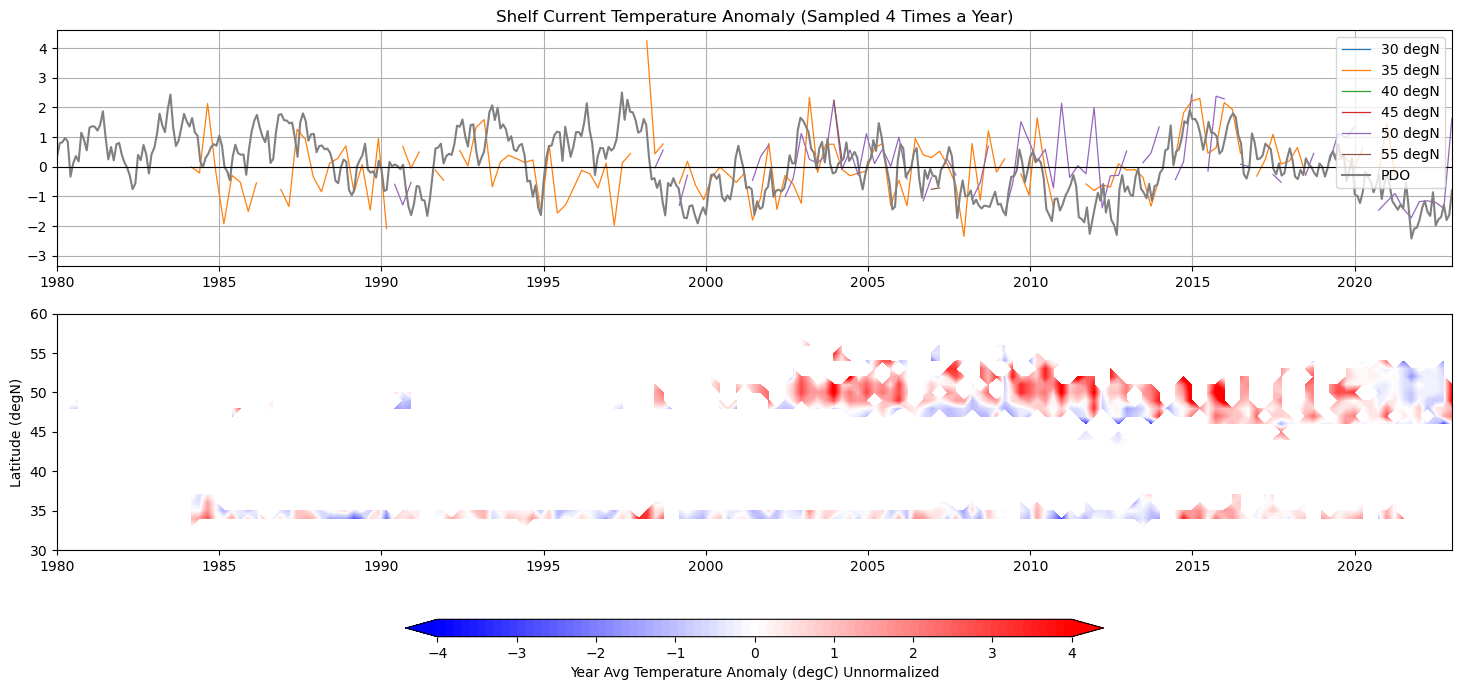

In [21]:
# Shelf Current temperature latitude trends
obs_used = obs_shelf

start_yr = min(obs_used['year'])
end_yr = max(obs_used['year'])


lat_ranges = np.arange(30,60,1) # Every 1 degree north
variable_str = 'temperature (degC)' # Using temperature

anom_array = contour_prep_lat(obs_used, start_yr, end_yr, lat_ranges, variable_str)


x_yr_4times = np.linspace(start_yr, end_yr, num=(end_yr-start_yr)*4)
X,Y = np.meshgrid(x_yr_4times, lat_ranges[:-1])

fig, ax = plt.subplots(2,1, figsize=(18, 9))

for i in range(0, anom_array.shape[0], 5):
    lat_label = lat_ranges[i]
    ax[0].plot(x_yr_4times, zscore(anom_array[i], nan_policy='omit'), label=f'{lat_label} degN', linewidth=0.9)

# ax[0].plot(enso['decimal_yr'], zscore(enso['index']), c='grey', ls='-', label='ENSO')
ax[0].plot(pdo['decimal_yr'], zscore(pdo['index']), c='grey', ls='-', label='PDO')
# ax[0].plot(npgo['decimal_yr'], zscore(npgo['index'], nan_policy='omit'), c='grey', ls='-', label='NPGO')

ax[0].set_xlim([1980,2023])
ax[0].legend()
ax[0].axhline(0, color='black', linewidth=0.8)
ax[0].grid()
ax[0].set_title('Shelf Current Temperature Anomaly (Sampled 4 Times a Year)')

vmax=4
levels = np.linspace(-vmax, vmax, 80)
cp = ax[1].contourf(X,Y, anom_array, levels=levels, cmap='bwr', extend='both')

ax[1].set_ylabel('Latitude (degN)')
ax[1].set_xlim([1980,2023])
ax[1].set_ylim([30,60])


ticks = list(range(-vmax, vmax+1))
cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.1, aspect=40, shrink=0.5, ticks=ticks)
cbar.set_label('Year Avg Temperature Anomaly (degC) Unnormalized')

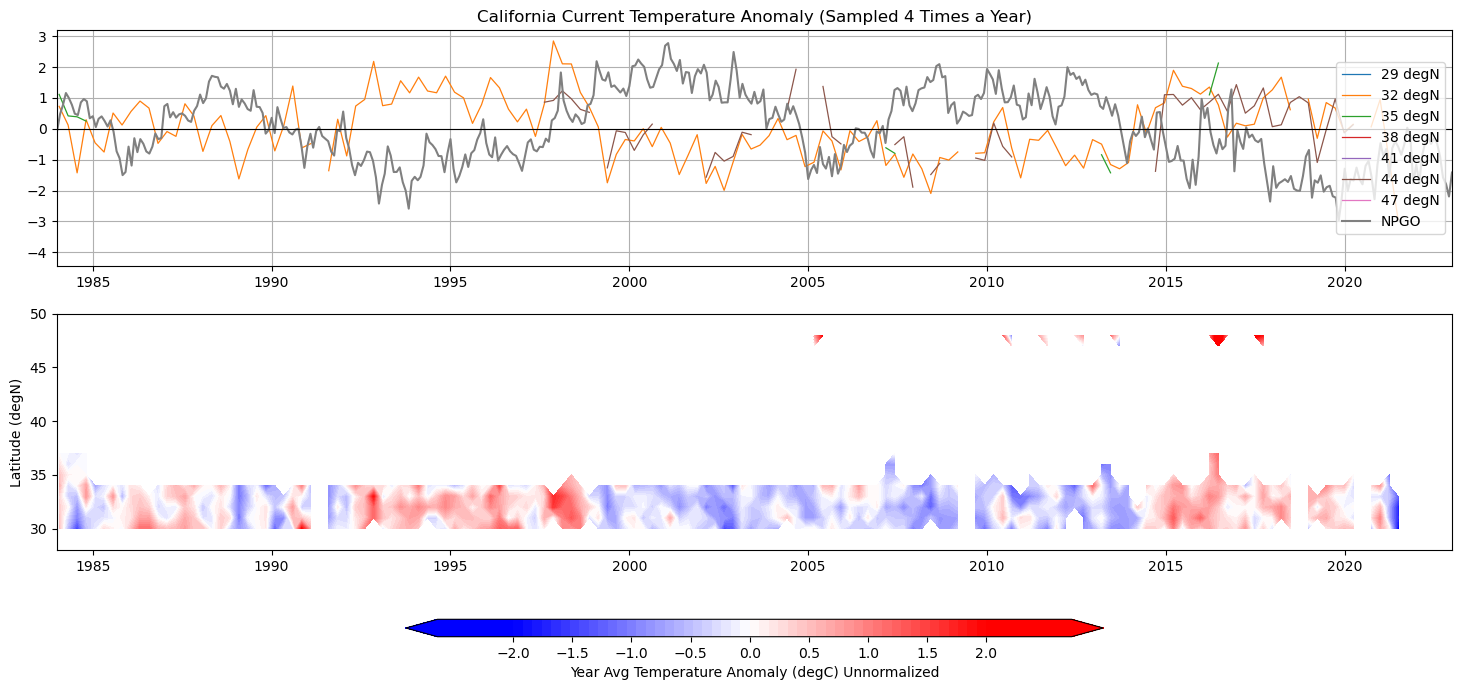

In [22]:
# California Current temperature latitude trends
obs_used = obs_cc

start_yr = min(obs_used['year'])
end_yr = max(obs_used['year'])


lat_ranges = np.arange(29,51,1) # Every degree N
variable_str = 'temperature (degC)' # Using temperature

anom_array = contour_prep_lat(obs_used, start_yr, end_yr, lat_ranges, variable_str)

x_yr_4times = np.linspace(start_yr, end_yr, num=(end_yr-start_yr)*4)
X,Y = np.meshgrid(x_yr_4times, lat_ranges[:-1])

fig, ax = plt.subplots(2,1, figsize=(18, 9))

for i in range(0, anom_array.shape[0], 3):
    lat_label = lat_ranges[i]
    ax[0].plot(x_yr_4times, zscore(anom_array[i], nan_policy='omit'), label=f'{lat_label} degN', linewidth=0.9)

# lat_mask = ((lat_ranges >= 100) & (lat_ranges <= 350))
# masked_lats = np.where(lat_mask)[0]  # indices of depths in range 100–350

# for idx in masked_lats[::4]:  # every 5th depth index in range
#     lat_label = lat_ranges[idx]
#     ax[0].plot(x_yr_4times, zscore(anom_array[idx], nan_policy='omit'), label=f'{lat_label}m', linewidth=0.9)

# ax[0].plot(enso['decimal_yr'], zscore(enso['index']), c='grey', ls='-', label='ENSO')
# ax[0].plot(pdo['decimal_yr'], zscore(pdo['index']), c='grey', ls='-', label='PDO')
ax[0].plot(npgo['decimal_yr'], zscore(npgo['index'], nan_policy='omit'), c='grey', ls='-', label='NPGO')

ax[0].set_xlim([1984,2023])
ax[0].legend(loc='right')
ax[0].axhline(0, color='black', linewidth=0.8)
ax[0].grid()
ax[0].set_title('California Current Temperature Anomaly (Sampled 4 Times a Year)')

vmax=4
# levels = np.linspace(-vmax, vmax, 80)
# cp = ax[1].contourf(X,Y, anom_array, levels=levels, cmap='bwr', extend='both')

cp = ax[1].contourf(X,Y, anom_array, levels=80, cmap='bwr', vmin=-2, vmax=2, extend='both')

ax[1].set_ylabel('Latitude (degN)')
ax[1].set_xlim([1984,2023])
ax[1].set_ylim([28,50])

ticks = [x/2 for x in range(-vmax, vmax+1)]
cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.1, aspect=40, shrink=0.5, ticks=ticks)
cbar.set_label('Year Avg Temperature Anomaly (degC) Unnormalized')

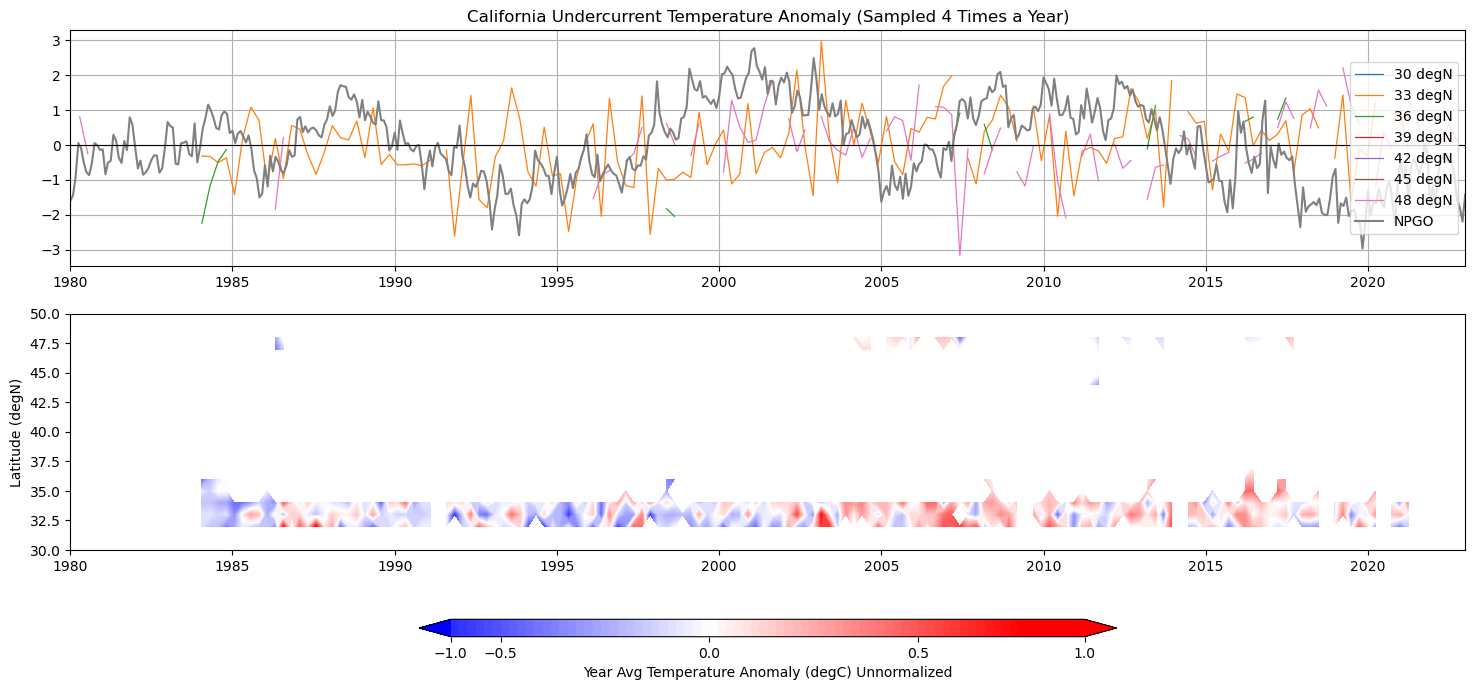

In [23]:
# California Undercurrent temperature latitude trends
obs_used = obs_cuc

start_yr = min(obs_used['year'])
end_yr = max(obs_used['year'])


lat_ranges = np.arange(30,50,1) # Every degree N
variable_str = 'temperature (degC)' # Using temperature

anom_array = contour_prep_lat(obs_used, start_yr, end_yr, lat_ranges, variable_str)

x_yr_4times = np.linspace(start_yr, end_yr, num=(end_yr-start_yr)*4)
X,Y = np.meshgrid(x_yr_4times, lat_ranges[:-1])

fig, ax = plt.subplots(2,1, figsize=(18, 9))

for i in range(0, anom_array.shape[0], 3):
    lat_label = lat_ranges[i]
    ax[0].plot(x_yr_4times, zscore(anom_array[i], nan_policy='omit'), label=f'{lat_label} degN', linewidth=0.9)

# lat_mask = ((lat_ranges >= 100) & (lat_ranges <= 350))
# masked_lats = np.where(lat_mask)[0]  # indices of depths in range 100–350

# for idx in masked_lats[::4]:  # every 5th depth index in range
#     lat_label = lat_ranges[idx]
#     ax[0].plot(x_yr_4times, zscore(anom_array[idx], nan_policy='omit'), label=f'{lat_label}m', linewidth=0.9)

# ax[0].plot(enso['decimal_yr'], zscore(enso['index']), c='grey', ls='-', label='ENSO')
# ax[0].plot(pdo['decimal_yr'], zscore(pdo['index']), c='grey', ls='-', label='PDO')
ax[0].plot(npgo['decimal_yr'], zscore(npgo['index'], nan_policy='omit'), c='grey', ls='-', label='NPGO')

ax[0].set_xlim([1980,2023])
ax[0].legend(loc='right')
ax[0].axhline(0, color='black', linewidth=0.8)
ax[0].grid()
ax[0].set_title('California Undercurrent Temperature Anomaly (Sampled 4 Times a Year)')

vmax=2
# levels = np.linspace(-vmax, vmax, 80)
# cp = ax[1].contourf(X,Y, anom_array, levels=levels, cmap='bwr', extend='both')

cp = ax[1].contourf(X,Y, anom_array, levels=80, cmap='bwr', vmin=-0.75,vmax=0.75, extend='both')

ax[1].set_ylabel('Latitude (degN)')
ax[1].set_xlim([1980,2023])
ax[1].set_ylim([30,50])

ticks = [x/2 for x in range(-vmax, vmax+1)]
cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.1, aspect=40, shrink=0.5, ticks=ticks)
cbar.set_label('Year Avg Temperature Anomaly (degC) Unnormalized')

## Average Temp Depth Profiles

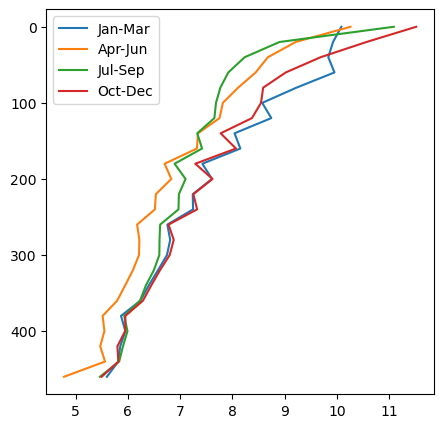

In [24]:
# Shelf Current Avg Temp Profiles
obs_used = obs_shelf

depth_ranges = np.arange(0,500,20) # Every 20m depth range
variable_str = 'temperature (degC)'

profile_clim_avg = avg_profile_4seasons_depth(obs_used, depth_ranges, variable_str)

fig, ax = plt.subplots(1,1, figsize=(5, 5))
ax.plot(profile_clim_avg.T, np.tile(depth_ranges[:-1], (4,1)).T)
ax.invert_yaxis()
ax.legend(('Jan-Mar', 'Apr-Jun', 'Jul-Sep', 'Oct-Dec'))

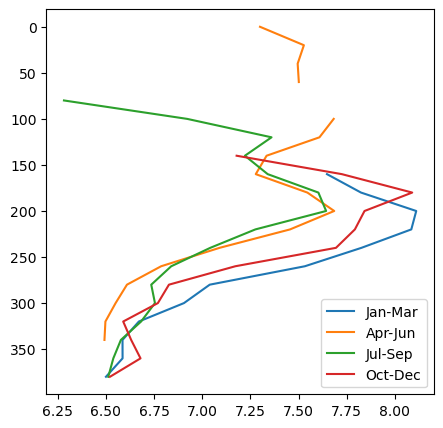

In [25]:
# California Undercurrent Avg Temp Profiles
obs_used = obs_cuc

depth_ranges = np.arange(0,500,20) # Every 20m depth range
variable_str = 'temperature (degC)'

profile_clim_avg = avg_profile_4seasons_depth(obs_used, depth_ranges, variable_str)

fig, ax = plt.subplots(1,1, figsize=(5, 5))
ax.plot(profile_clim_avg.T, np.tile(depth_ranges[:-1], (4,1)).T)
ax.invert_yaxis()
ax.legend(('Jan-Mar', 'Apr-Jun', 'Jul-Sep', 'Oct-Dec'))

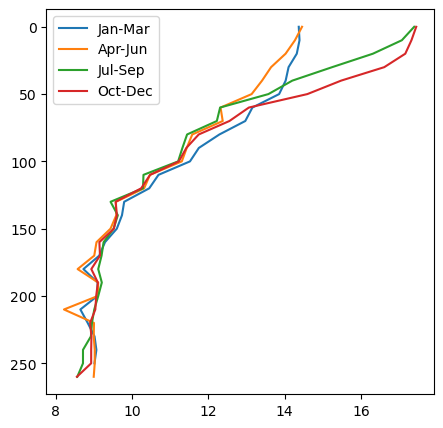

In [26]:
# California Current Avg Temp Profiles
obs_used = obs_cc

depth_ranges = np.arange(0,500,10) # Every 10m depth range
variable_str = 'temperature (degC)'

profile_clim_avg = avg_profile_4seasons_depth(obs_used, depth_ranges, variable_str)

fig, ax = plt.subplots(1,1, figsize=(5, 5))
ax.plot(profile_clim_avg.T, np.tile(depth_ranges[:-1], (4,1)).T)
ax.invert_yaxis()
ax.legend(('Jan-Mar', 'Apr-Jun', 'Jul-Sep', 'Oct-Dec'))